## Описание проекта

**Заказчик:**
интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры. 

**Данные:**
исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. 

**Задача проекта:**
- выявить определяющие успешность игры закономерности, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании
- разработать принципы планирования рекламной кампании на следующий год

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

from scipy import stats as st
import itertools
import operator

%config InlineBackend.figure_format = 'retina'

## Обработка данных

### Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

NB: Данные за 2016 год могут быть неполными.

----
КОММЕНТАРИЙ: В наборе данных есть год выпуска игры и количество проданных копий игры. Данных по выручке / прибыльности нет.

In [2]:
data = pd.read_csv('/datasets/games.csv')


In [3]:
data.sample(5)

Name Platform  Year_of_Release  \
16294  Adventure Time: The Secret of the Nameless      X360           2014.0   
532                             Monster Hunter Tri      3DS           2011.0   
10400             Trauma Center: Under the Knife 2       DS           2008.0   
3389                                NFL Blitz 2001       PS           2000.0   
2379                                           Gex       PS           1995.0   

              Genre  NA_sales  EU_sales  JP_sales  Other_sales  Critic_Score  \
16294     Adventure      0.01      0.00      0.00         0.00           NaN   
532    Role-Playing      0.46      0.29      1.96         0.07           NaN   
10400    Simulation      0.10      0.00      0.00         0.01          79.0   
3389         Sports      0.33      0.22      0.00         0.04          70.0   
2379       Platform      0.49      0.33      0.00         0.06           NaN   

      User_Score Rating  
16294        NaN    NaN  
532          NaN    NaN  
10400        8.5      T  
3389         tbd      E  
2379         NaN    NaN

In [4]:
data.info()
data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


count         mean        std     min     25%      50%  \
Year_of_Release  16446.0  2006.484616   5.877050  1980.0  2003.0  2007.00   
NA_sales         16715.0     0.263377   0.813604     0.0     0.0     0.08   
EU_sales         16715.0     0.145060   0.503339     0.0     0.0     0.02   
JP_sales         16715.0     0.077617   0.308853     0.0     0.0     0.00   
Other_sales      16715.0     0.047342   0.186731     0.0     0.0     0.01   
Critic_Score      8137.0    68.967679  13.938165    13.0    60.0    71.00   

                     75%      max  
Year_of_Release  2010.00  2016.00  
NA_sales            0.24    41.36  
EU_sales            0.11    28.96  
JP_sales            0.04    10.22  
Other_sales         0.03    10.57  
Critic_Score       79.00    98.00

- названия колонок - есть строчные буквы
- годы выпуска - есть пробелы
- годы выпуска - с 1980 до 2016
- Critic_Score - есть пробелы
- изменить тип колонок для Year_of_Release to int, user_score to float, Critic_Score to int


Уберем прописные символы из названий колонок

In [5]:
data.rename(str.lower, axis='columns', inplace=True)

дубликатов нет

In [6]:
data.duplicated().sum()

0

### Задание: Обработайте пропуски при необходимости

Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
Опишите причины, которые могли привести к пропускам;
Обратите внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберите это значение и опишите, как его обработать;

Доля пропущенных значений в поле year_of_release - 1,6%. Так как данные о годе выпуска критичны для дальнейшего анализа, удалю эти записи из набора данных

In [7]:
print('доля NAN в поле year_of_release: ', (data.query('year_of_release.isna() == True').shape[0] / data.shape[0]))
data = data.query('year_of_release.isna() == False')

доля NAN в поле year_of_release:  0.01609332934489979


В поле 'user_score' 25% записей со значением встречается значением  'tbd'. 
Значений 0 нет. 
Чтобы 'tbd' не мешало привести поле к цифровому формату, заменю его на 0 и буду учитывать это при дальнейшем анализе

In [8]:
display(data['user_score'].value_counts(normalize=True).head(1))
data.loc[data['user_score'] == 'tbd', 'user_score'] = 0

tbd    0.241488
Name: user_score, dtype: float64

Приведу поле 'year_of_release' к формату integer, поля 'critic_score', 'user_score' к формату float и заполню NaN нулями. Для анализа не важно, пропущено поле 'user_score' или оно еще только ждет заполнения

In [9]:
# в обоих полях нет нулей
data.query('critic_score == 0')

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []

In [10]:
data['year_of_release'] = data['year_of_release'].astype(int)
for i in ['critic_score', 'user_score']:
    data[i] = pd.to_numeric(data[i], errors='ignore').fillna(0) 

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     16446 non-null  float64
 9   user_score       16446 non-null  float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


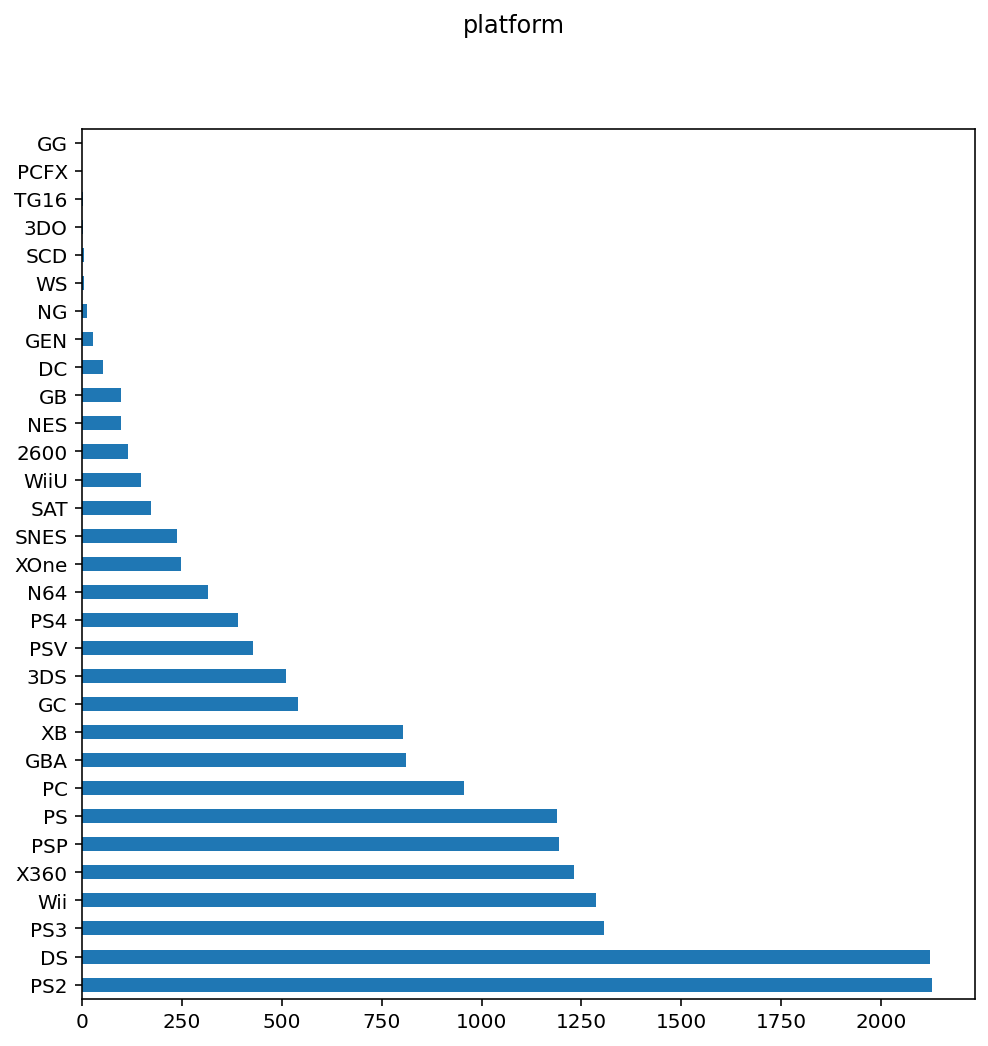

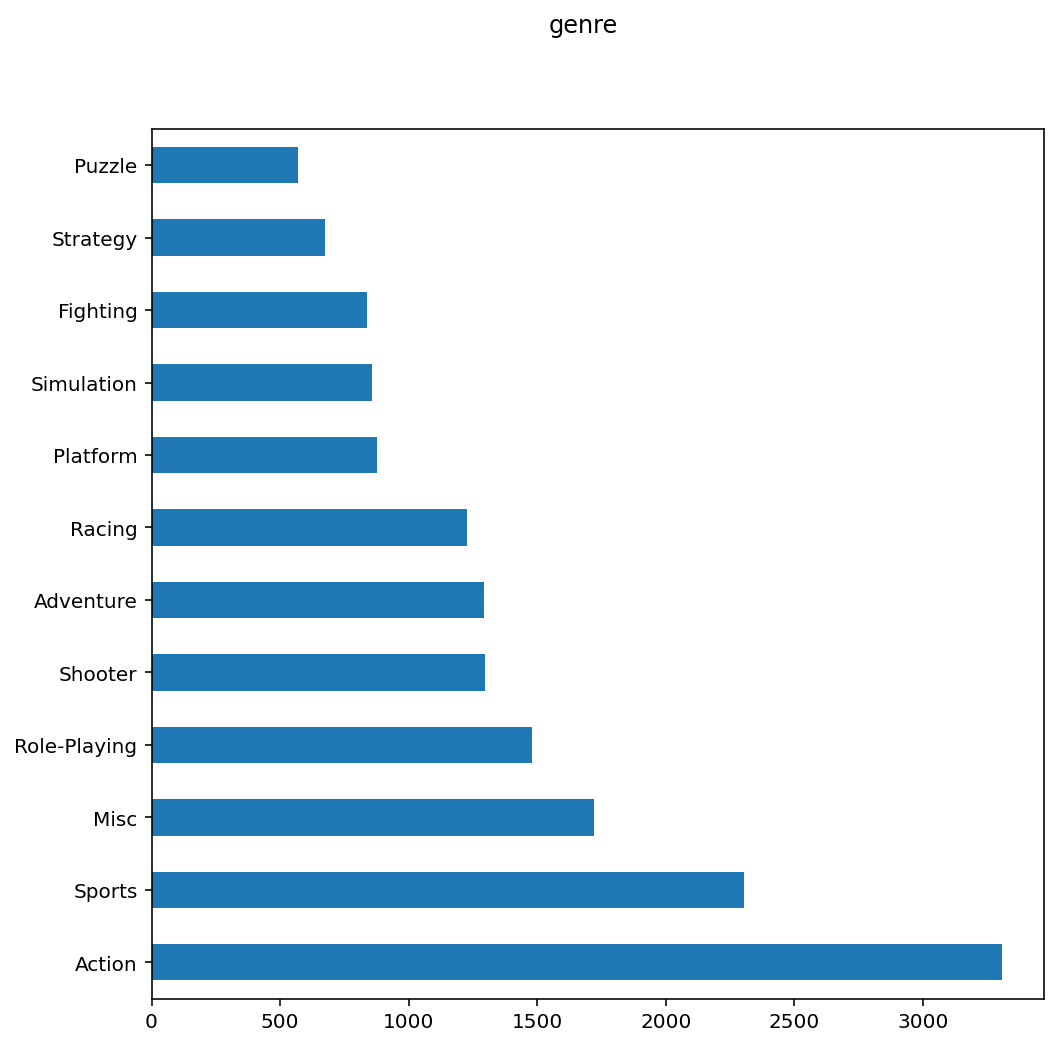

In [11]:
for i in ['platform', 'genre']:
    fig = plt.figure(figsize=(8,8))
    data[i].value_counts(ascending=False).plot(kind='barh')
    fig.suptitle(i);

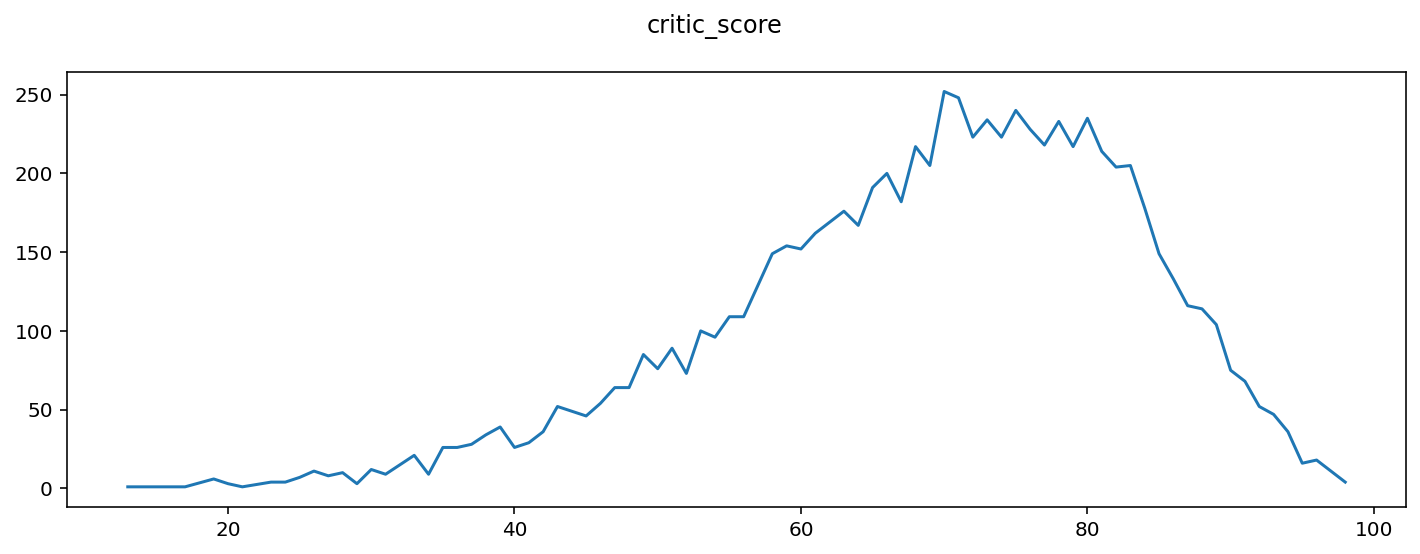

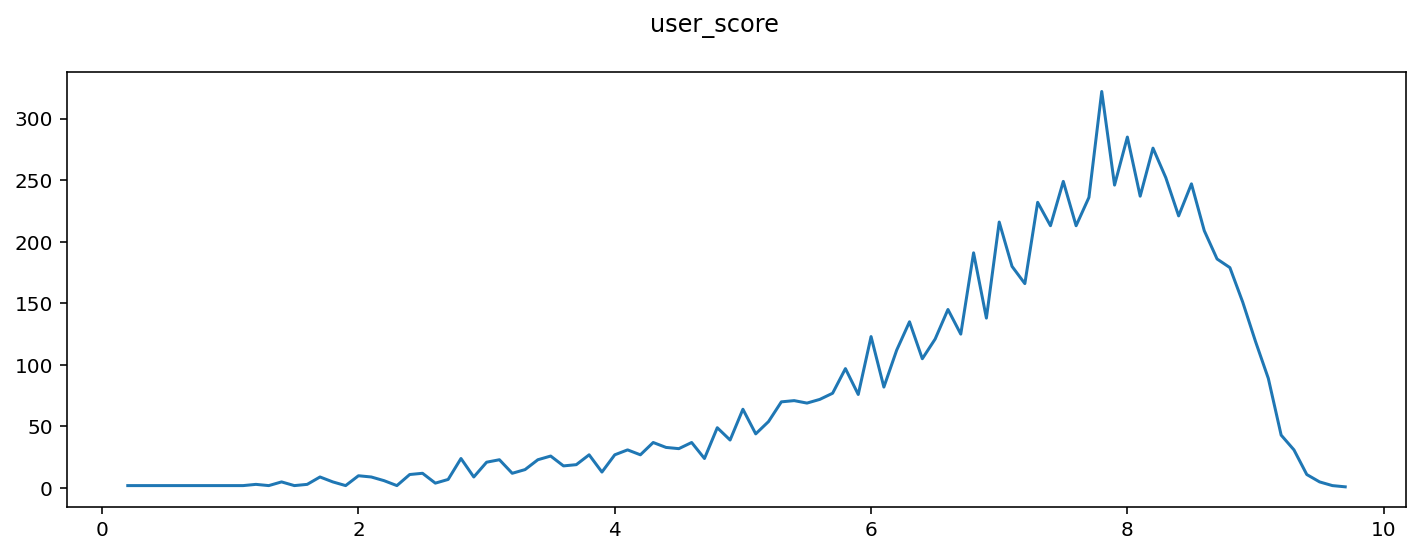

In [12]:
for i in ['critic_score', 'user_score']:
    fig = plt.figure(figsize=(12,4))
    data.loc[data[i] > 0, i].value_counts().sort_index().plot()
    fig.suptitle(i);

#### Задание: Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [13]:
data = data.assign(
    total_sales = lambda x: x['na_sales'] + x['eu_sales'] + x['jp_sales'] + x['other_sales']   
    ) 
data.sample(1)

name platform  year_of_release   genre  na_sales  eu_sales  \
416  Gran Turismo (PSP)      PSP             2009  Racing       0.5      1.58   

     jp_sales  other_sales  critic_score  user_score rating  total_sales  
416      0.31         0.87           0.0         0.0    NaN         3.26

In [15]:
data['rating'] = data['rating'].fillna('not defined')
data = data.query('not (name.isna() or genre.isna())')
data.shape[0]

16444

In [16]:
(
    data.groupby('rating')[['na_sales', 'eu_sales','jp_sales', 'other_sales', 'total_sales']]
    .agg(sum).sort_values('total_sales')
    .style.bar(color='gold', vmin=0)
)

## Исследовательский анализ данных

#### Задание: Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

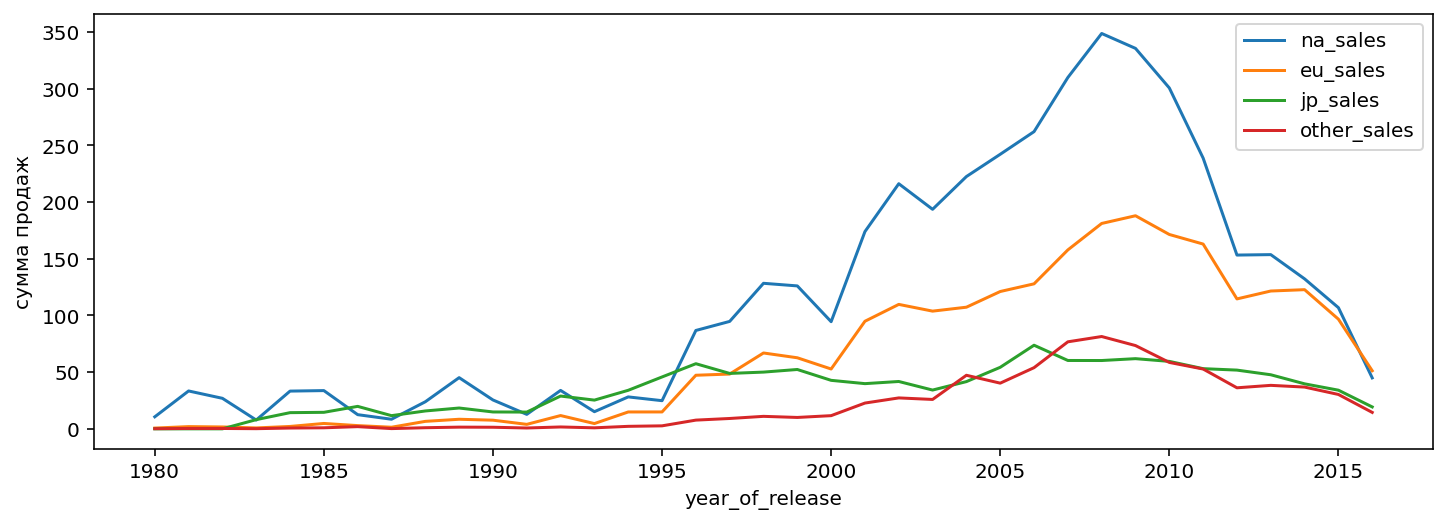

In [17]:
for i in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
#     fig = plt.figure(figsize=(12,4))
    data.groupby('year_of_release')[i].sum().plot(figsize=(12,4), legend=True, ylabel='сумма продаж')
    fig.suptitle(i);

ВЫВОД: Данные до 2000 года можем не учитывать при построении прогнозов. Продаж было относительно мало + простой здравый смысл говорит, что ландшафт существенно изменился за 20 лет. Отброшу устаревшую информацию.

In [18]:
data = data.query('year_of_release > 1999')

#### Задание: Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

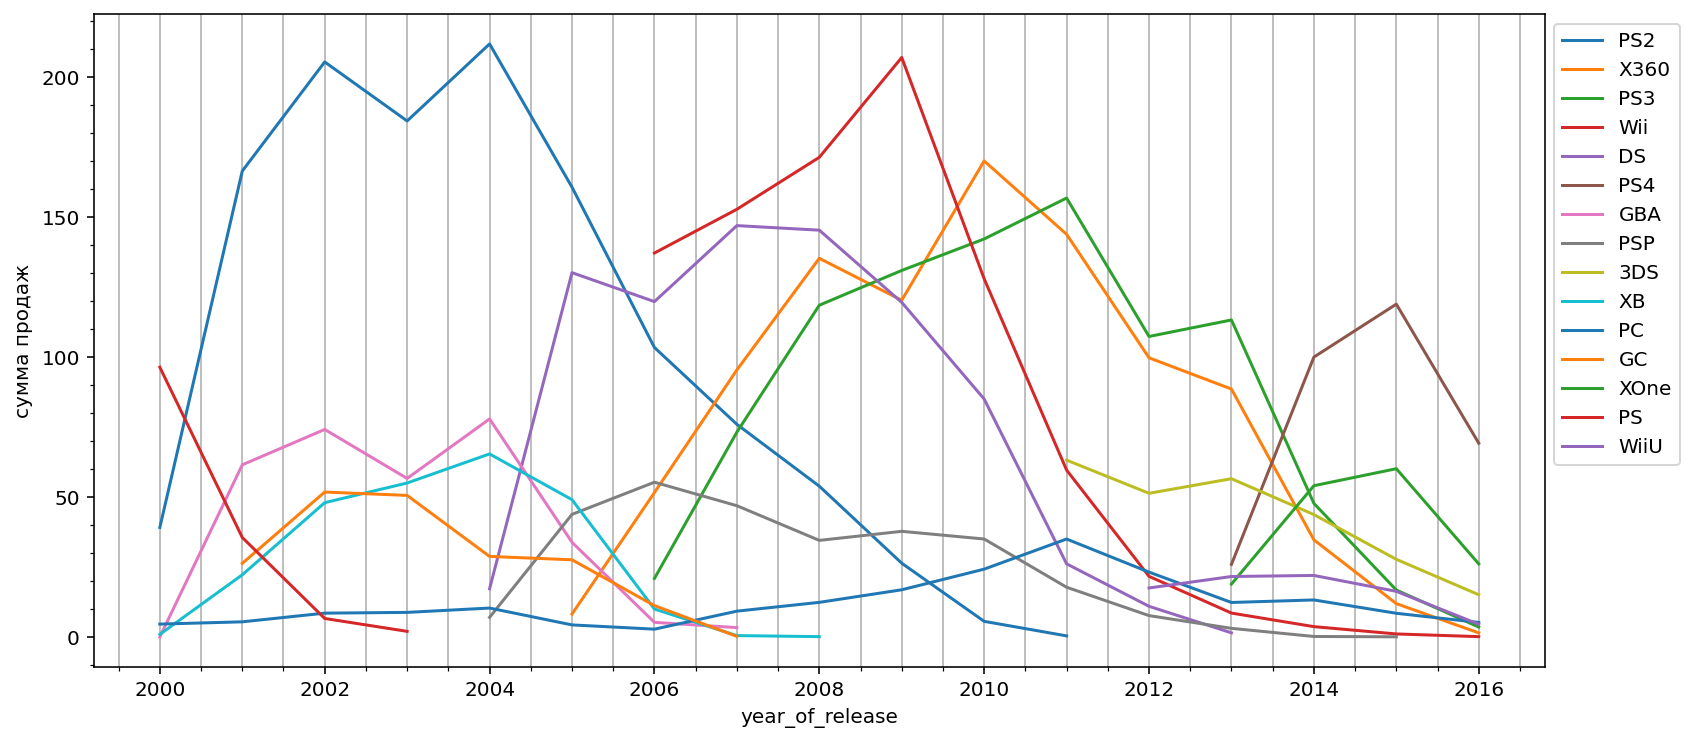

In [19]:
platforms=(
    data
    .pivot_table(columns = 'year_of_release', index = 'platform', values='total_sales', aggfunc='sum', margins=True)
    .drop('All', axis=0)
    .sort_values(by='All', ascending=False)
    .drop('All', axis=1)
)

platforms.head(15).T.plot(figsize=(13,6), ylabel='сумма продаж')

plt.minorticks_on()
plt.grid(visible=True, which='both', axis='x')
plt.legend(bbox_to_anchor=(1.1, 1));

ВЫВОДЫ: 
- платформы как правило выходят на пик за 3 - 5 лет
- в целом продажи в имеющемся наборе данных замедляются

#### Задание: Возьмите данные за соответствующий актуальный период. Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Построим тот же график для всех платформ, на которых выходили игры с ~~2012~~ 2014 до 2016 года

platform
PSP      11.19
DS       12.55
Wii      35.37
PSV      49.18
PC       62.65
WiiU     82.19
XOne    159.32
3DS     194.61
X360    236.54
PS3     288.79
PS4     314.14
dtype: float64

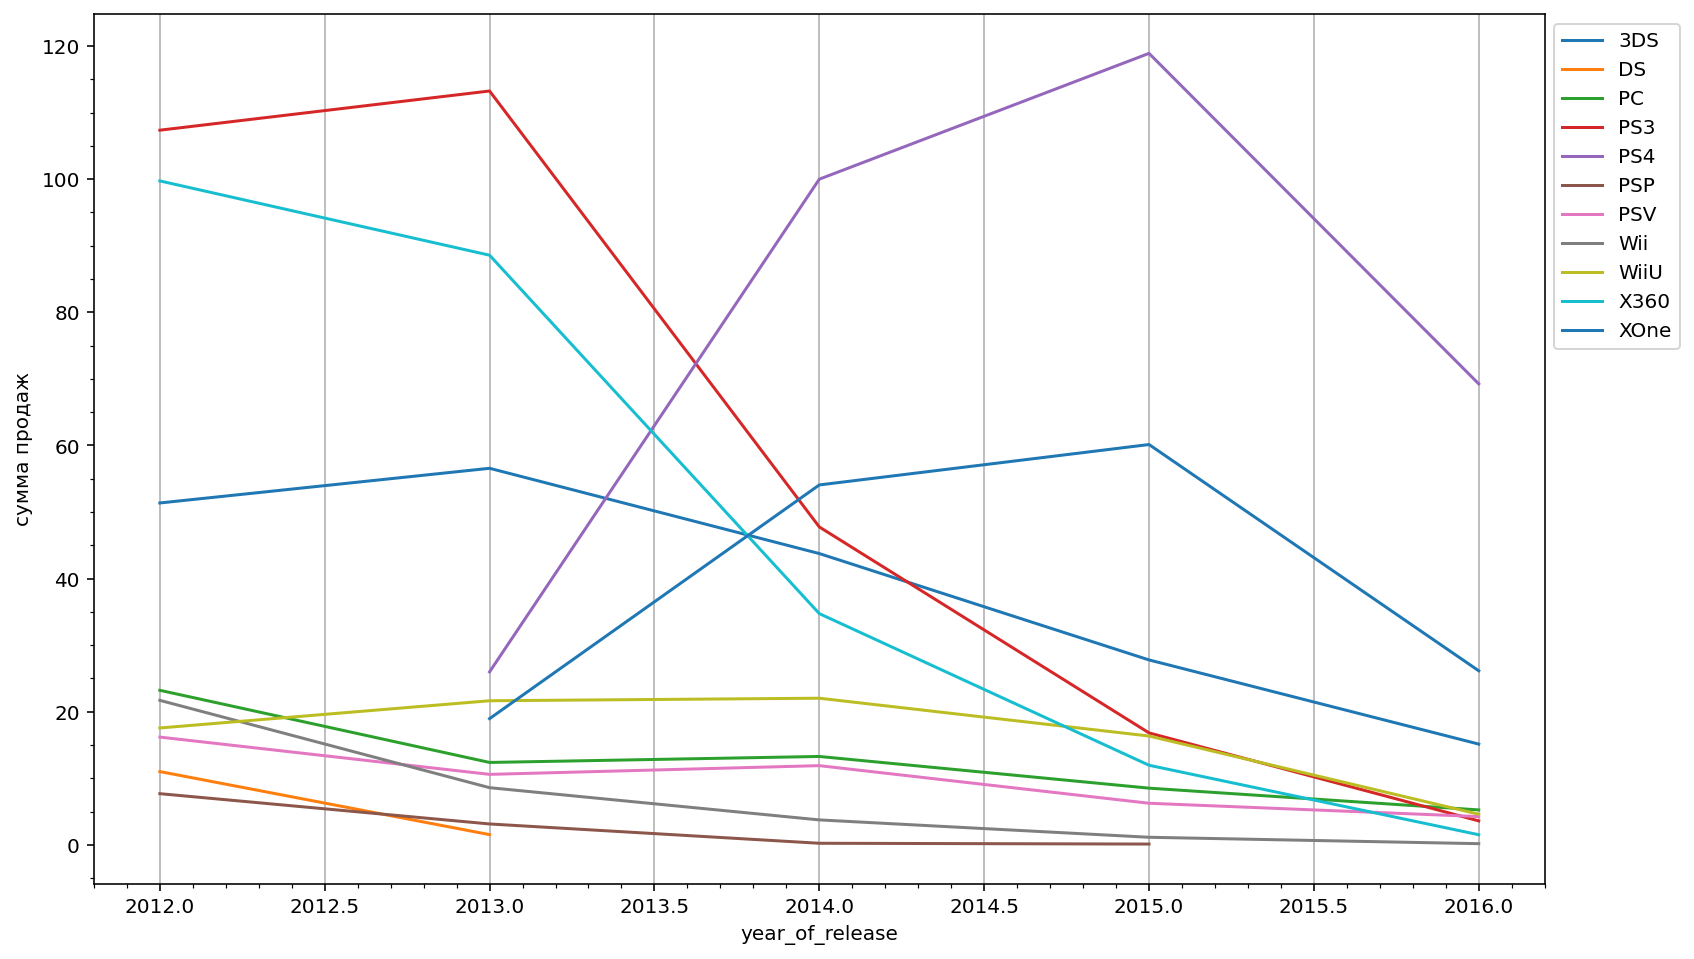

In [20]:
platforms2=(
    data
    .pivot_table(index = 'year_of_release', columns = 'platform', values='total_sales', aggfunc='sum')
    .tail(5)
    .dropna(axis=1, how='all')
)

display(platforms2.sum().sort_values())

platforms2.plot(figsize=(13,8), ylabel='сумма продаж')

plt.minorticks_on()
plt.grid(visible=True, which='major', axis='x')
plt.legend(bbox_to_anchor=(1.1, 1));

Явных лидеров не видно, все платформы либо показывают стабильный результат либо идут на спад.

Посмотрим отобранные платформы в динамике с 2000 года

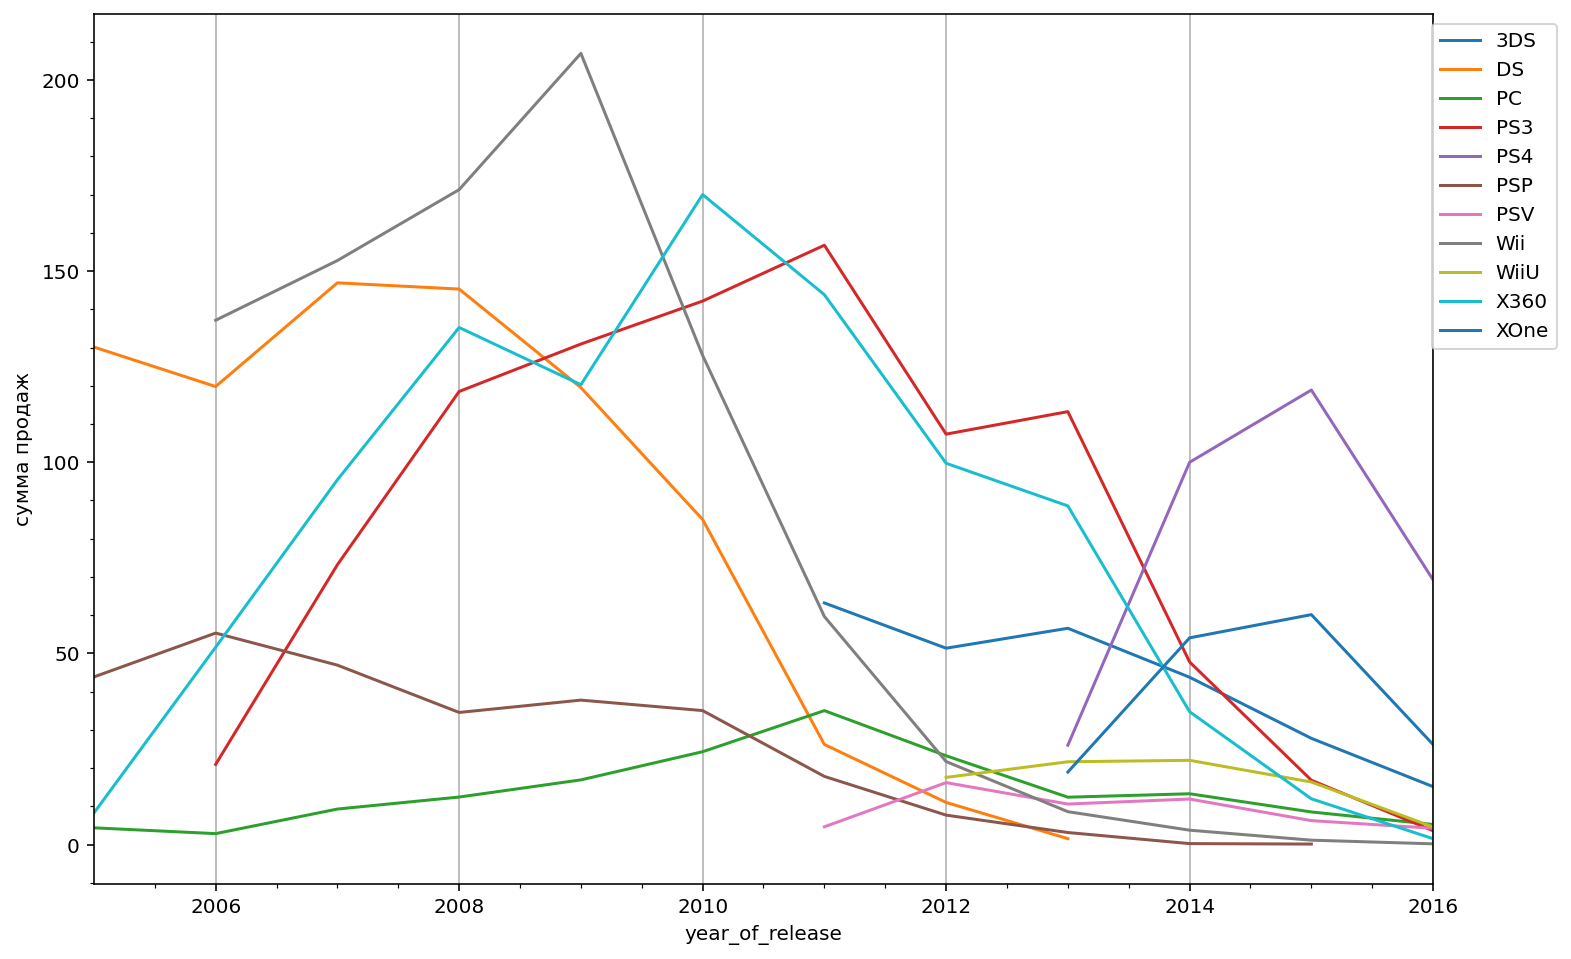

In [21]:
platforms.T[platforms2.columns].plot(figsize=(12,8), ylabel='сумма продаж', xlim=(2005,2016))

plt.minorticks_on()
plt.grid(visible=True, which='major', axis='x')
plt.legend(bbox_to_anchor=(1.1, 1));

ВЫВОДЫ:
- явных лидеров нет

- в предыдущие годы некоторые платформы показывали паттерн "отскока" - достигали пика, резко падали, достигали второго пика и падали окончательно. Такой отскок происходил только в случае если первое падение не достигало изначального минимума продаж. Из имеющихся платформ такой паттерн еще может показать PS4. <span style='background :gold' >Кроме того, данные за 2016 год могут быть неполными, что также добавляет ей очков</span>.

- есть небольшие, но стабильные уже много лет платформы PC и PSV. Они скорее всего не покажут резкого роста, но и особо не просядут.

- Wii явно прошла пик, но также стабилизировалась, можно оставить в пуле.

- Остальные платформы скорее всего сходят с дистанции.

Построим еще раз график с динамикой отобранных платформ.

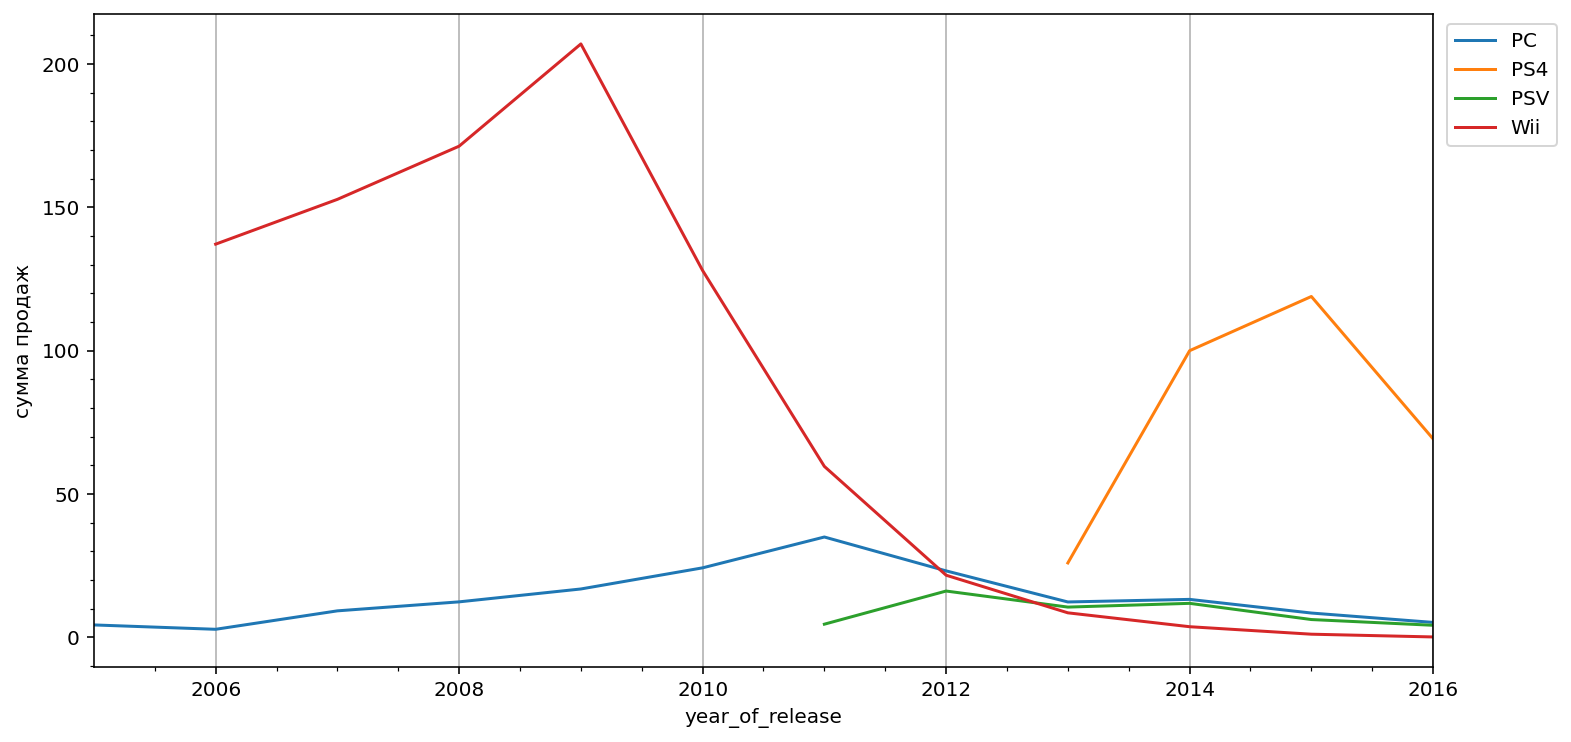

In [22]:
platforms.T[['PC', 'PS4', 'PSV', 'Wii']].plot(figsize=(12,6), ylabel='сумма продаж', xlim=(2005,2016))

plt.minorticks_on()
plt.grid(visible=True, which='major', axis='x')
plt.legend(bbox_to_anchor=(1.1, 1));

#### Задание: Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [23]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales'],
      dtype='object')

''

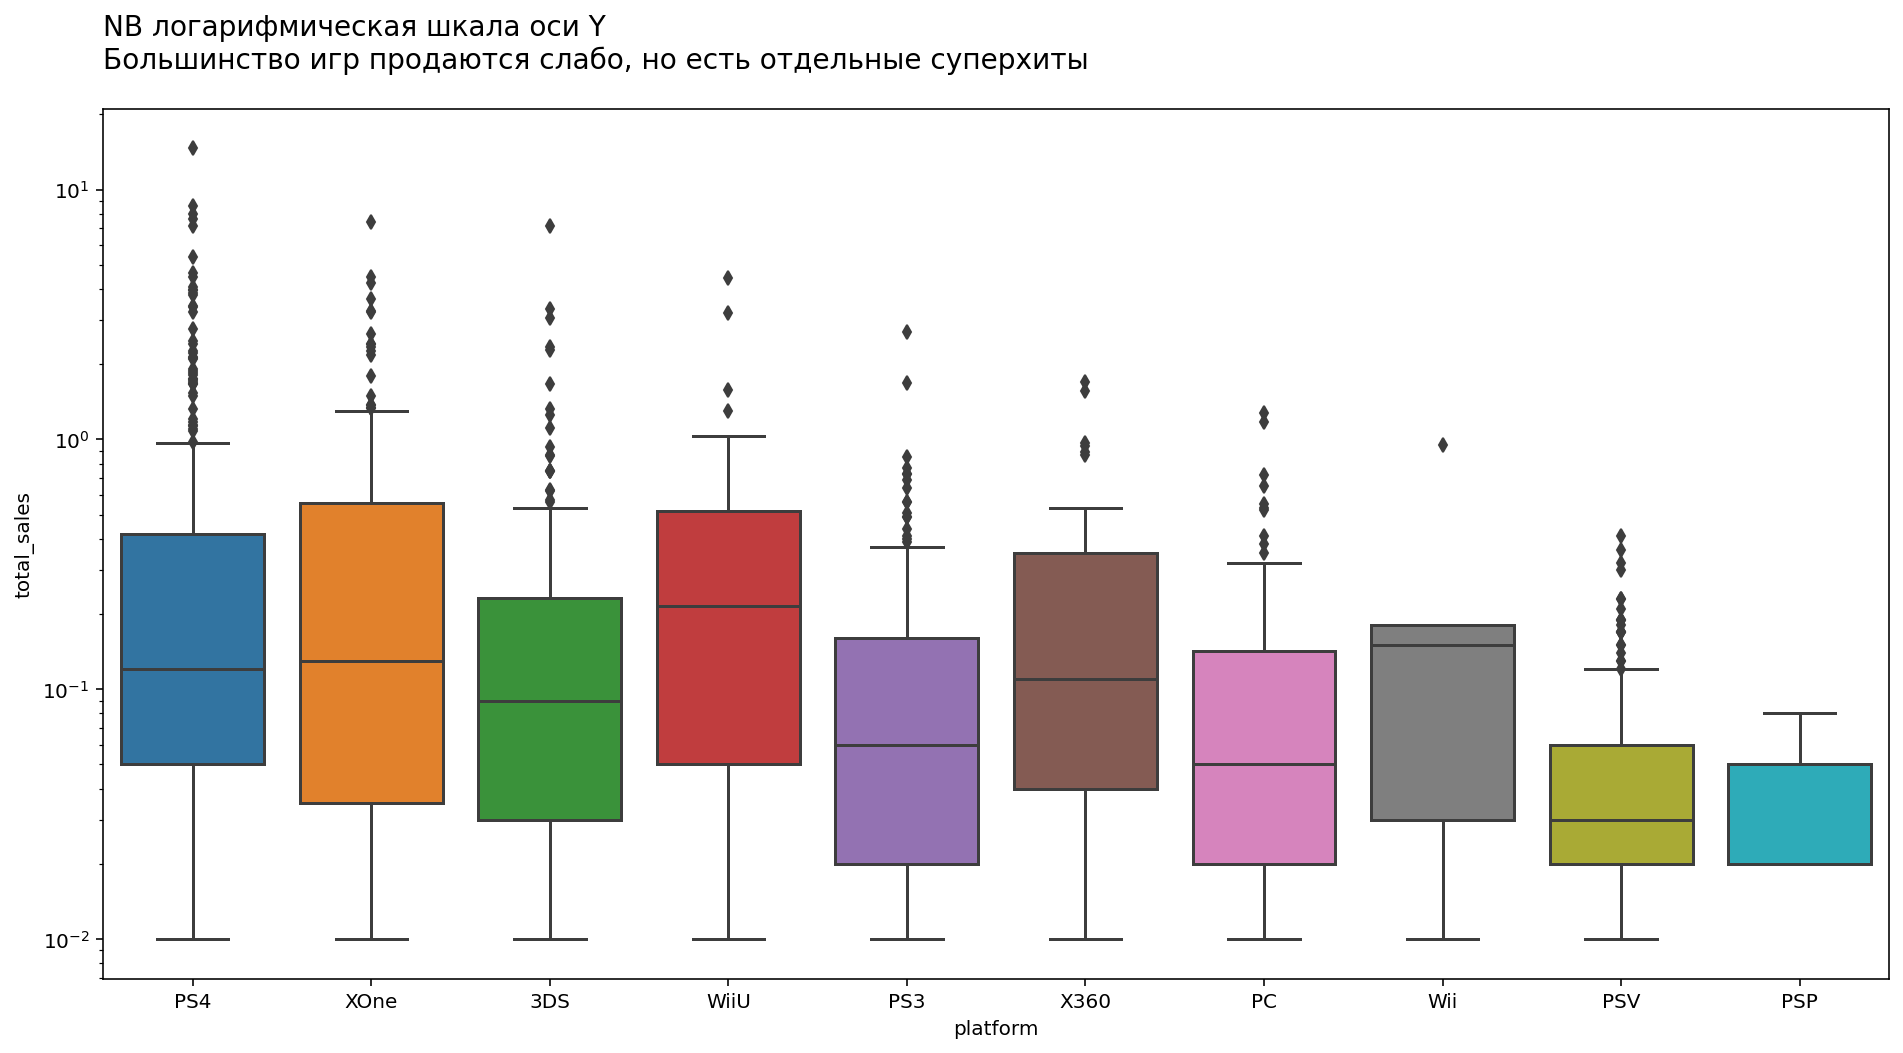

In [24]:
plt.figure(figsize=(16,8))
sns.boxplot(x="platform",
            y="total_sales", 
            data=data.query('year_of_release > 2014'))
plt.yscale('log')
plt.title('NB логарифмическая шкала оси Y \nБольшинство игр продаются слабо, но есть отдельные суперхиты', loc='left', pad=20, fontsize=14)
;

''

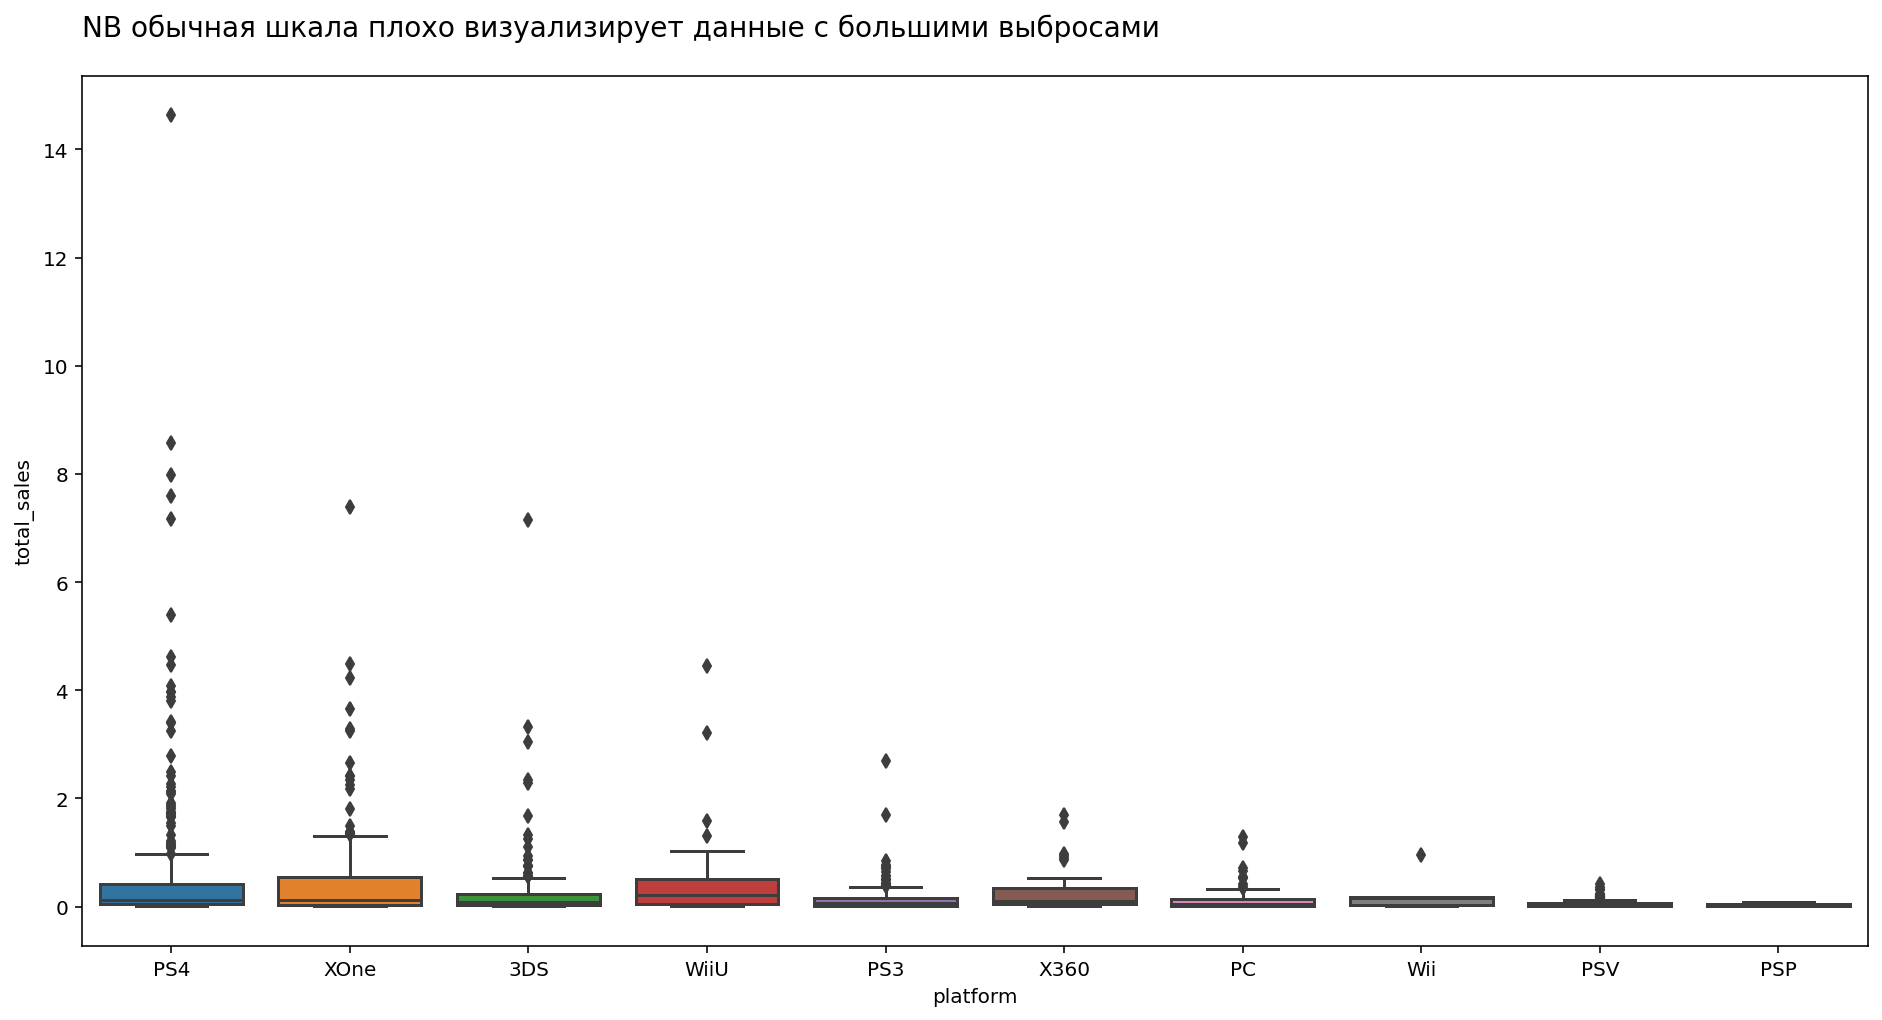

In [25]:
plt.figure(figsize=(16,8))
sns.boxplot(x="platform",
            y="total_sales", 
            data=data.query('year_of_release > 2014'))
# plt.yscale('log')
plt.title('NB обычная шкала плохо визуализирует данные с большими выбросами', loc='left', pad=20, fontsize=14)
;

ВЫВОД: Большинство игр продаются слабо, но у многих платформ есть отдельные хиты и суперхиты. 

In [28]:
ttl = data['total_sales'].sum()

display (
    data
    .groupby('name')['total_sales'].sum().sort_values(ascending=False).head(10).reset_index()
    .assign(pct_of_total = lambda x: x['total_sales'] / ttl)
    .style.format('{:.2%}', subset='pct_of_total')
)

#### Задание: Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

так как в наборе данных довольно много пробелов в отзывах пользователей и критиков, выберу платформу из топ-15, в которой набор данных наиболее полный

''

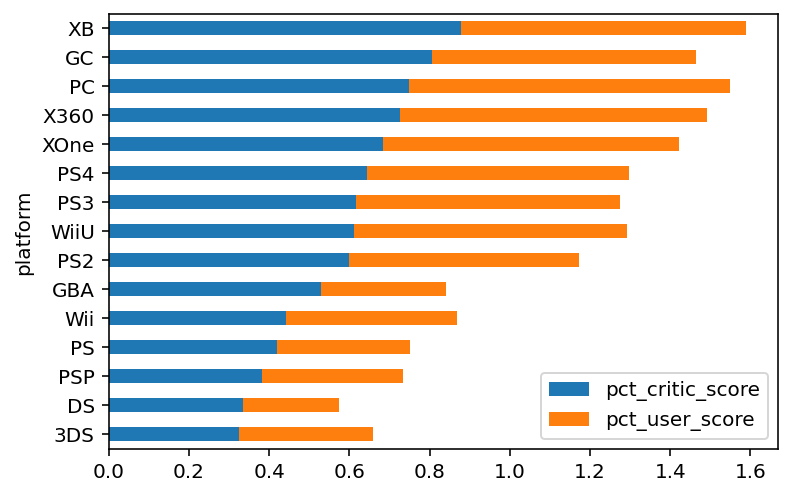

In [29]:
rated = (
    data
    .assign(
        pct_critic_score = lambda x: x['critic_score'] > 0,
        pct_user_score = lambda x: x['user_score'] > 0
    )
    .groupby('platform')
    .agg({'total_sales': 'sum', 'pct_critic_score':'mean', 'pct_user_score':'mean' })
    .sort_values(by='total_sales', ascending=False)
    .head(15)
    )

display(rated.style.bar(color='gold') )
rated[['pct_critic_score', 'pct_user_score']].sort_values(by='pct_critic_score').plot(kind='barh', stacked=True)
;

Проанализирую платформу X360, она в топе и по продажам и по количеству рейтингов. Пик популярности тоже был относительно недавно.

''

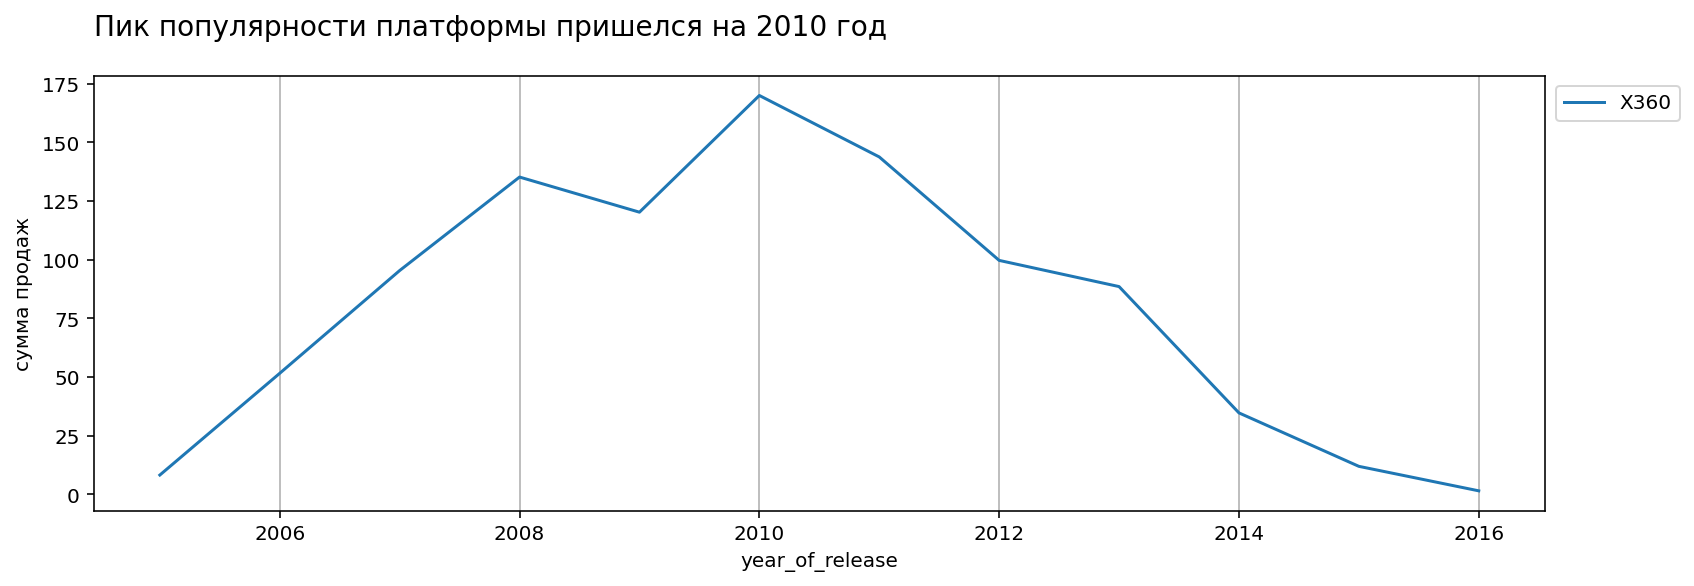

In [30]:
platforms.T['X360'].plot(figsize=(13,4), ylabel='сумма продаж')

plt.grid(visible=True, which='major', axis='x')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.title('Пик популярности платформы пришелся на 2010 год', pad=20, loc='left', fontsize=14)
;

Построим пузырьковую диаграмм для отзывов критиков, отзывов пользователей и продаж

In [31]:
fig = px.scatter(
    data.query('platform == "X360"'), 
    x="critic_score", y="user_score",
    size="total_sales", color="total_sales",
    hover_name="name",  size_max=30,
    width=600, height=600, 
    color_continuous_scale=px.colors.sequential.Jet,
    title='Размер маркера = общая сумма продаж; <br>хиты получили высокие оценки критиков'
    )

fig.show()

ВЫВОД ПО ВИЗУАЛИЗАЦИИ: 
- хиты часто получают более высокие оценки критиков (от 60 и выше)
- оценки пользователей слабее коррелируют с супер-успехом игры
- есть положительная корреляция между оценками критиков и оценками пользователей
- как мы помним, в продажах игр важную роль играют хиты. Можно предположить, что анализ основной массы игр, без хитов, мог бы дать другие результаты.

Посчитаю коэффициент корреляции Пирсона отдельно для каждой пары, так как если сформировать набор данных, отбросив записи, в которых нет И оценки критиков И оценки пользователей, теряется существенное количество записей.

In [32]:
for i in ['critic_score', 'user_score']:
    
    df = data.loc[(data['platform'] == "X360") & (data[i] > 0)]
    sales_corr = df[i].corr(df['total_sales'])   
    print (f'Корреляция total_sales с {i} : {sales_corr.round(2)}')


Корреляция total_sales с critic_score : 0.39
Корреляция total_sales с user_score : 0.11


Если показать то же самое графически, видно, что корреляция продаж с оценкой критиков не совсем линейная, усиливается за счет хитов продаж.

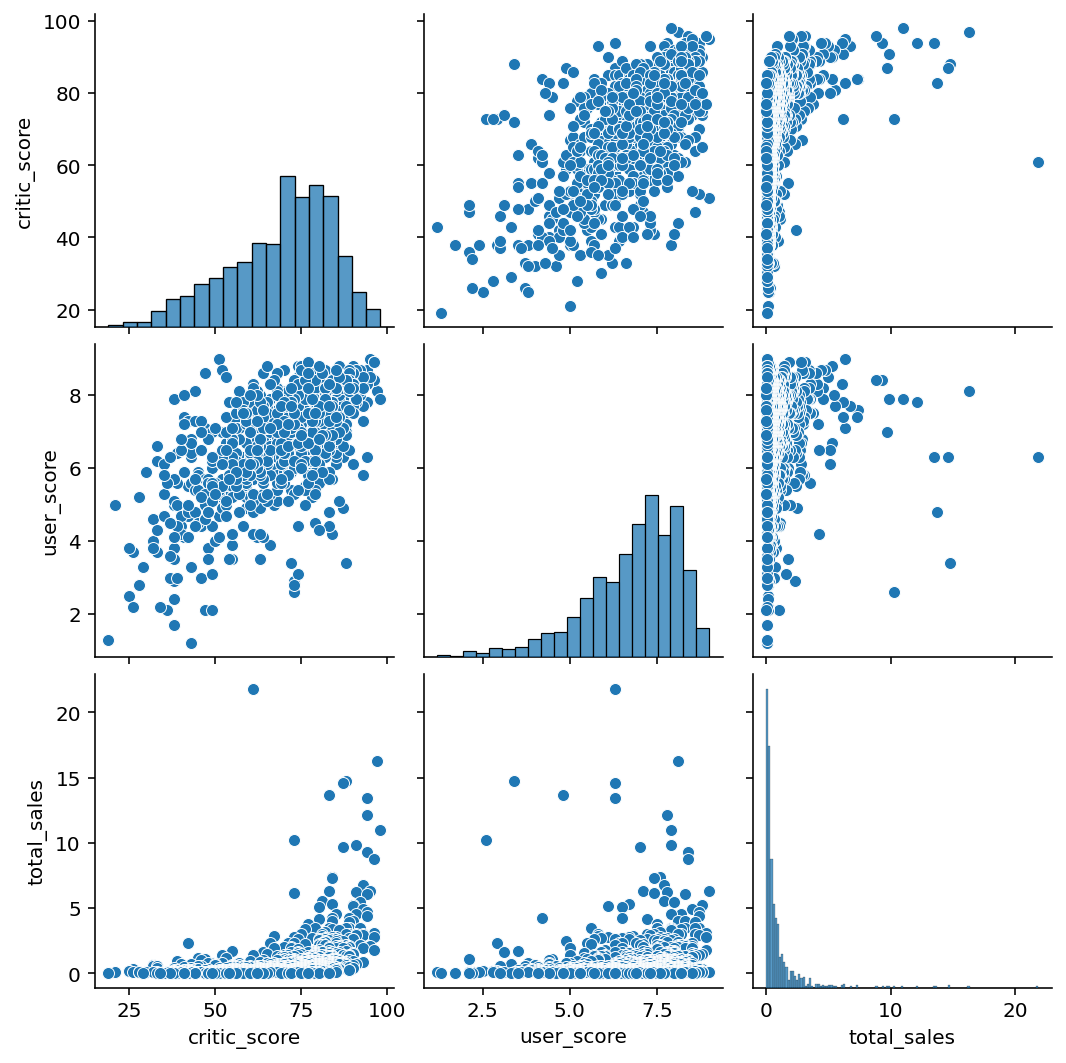

In [33]:
df360 = data.query('platform == "X360" and critic_score > 0 and user_score > 0 ')[['critic_score', 'user_score', 'total_sales']]
sns.pairplot(df360);

ВЫВОД: 
- Матрица корреляций показывает умеренную положительную корреляцию продаж с оценкой критиков и очень слабую - с оценкой пользователей 
- при этом оценки зрителей и пользователей в целом хорошо коррелируют

#### Задание: Соотнесите выводы с продажами игр на других платформах.

отброшу маленькие платформы, чтобы они не искажали результаты

In [34]:
small = (
    data
    .assign(
        count_critic_score = lambda x: x['critic_score'] > 0,
        count_user_score = lambda x: x['user_score'] > 0
    )
    .groupby('platform')
    .agg({'name':'count', 'count_critic_score':'sum', 'count_user_score':'sum'})
    .sort_values(by='name')
    .style.bar(color='lavender', vmin=0)
)

display (small)


print ('Отброшу 5 самых маленьких платформ, так как там либо мало игр, либо мало оценок, либо и то и другое')

In [35]:
small_list = small.index[0:5]
df = data.query('platform not in @small_list')
df.shape

(14191, 12)

Корреляция продаж по платформам с оценкой критиков и пользователей


''

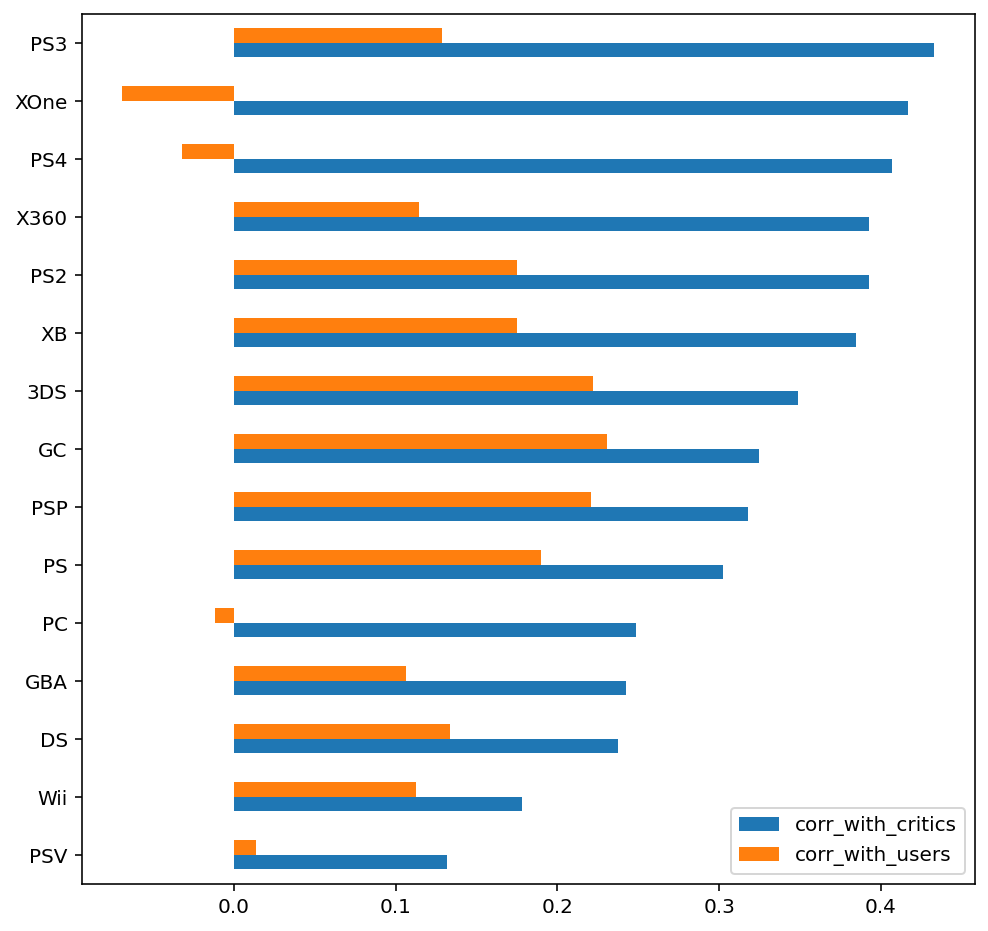

In [36]:
correlations = {} 

for i in df['platform'].unique():
    # чтобы максимально использовать данные, сформирую наборы данных, отбросив пропуски отдельно для каждого показателя 
    sales_corr_with_critic_score = df.query('platform == @i and critic_score > 0').corr()['total_sales']['critic_score']
    sales_corr_with_user_score = df.query('platform == @i and user_score > 0').corr()['total_sales']['user_score']
    correlations[i] = sales_corr_with_critic_score, sales_corr_with_user_score
    

print('Корреляция продаж по платформам с оценкой критиков и пользователей')    

(
    pd.DataFrame.from_dict(correlations, orient='index', columns=['corr_with_critics', 'corr_with_users'])
    .sort_values(by='corr_with_critics')
    .plot(kind='barh', figsize=(8,8))
)
;   

ВЫВОДЫ: 
- корреляция продаж с оценкой критиков положительная и в среднем умеренно-сильная
- разброс корреляции продаж с оценкой от слабой негативной до слабо-позитивной, поэтому сложно сказать что есть четкая тенденция.
- рассмотренная ранее платформа PS3 выглядит достаточно репрезентативно

#### Задание: Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Построим боксплот в разбивке по жанрам

In [37]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales'],
      dtype='object')

''

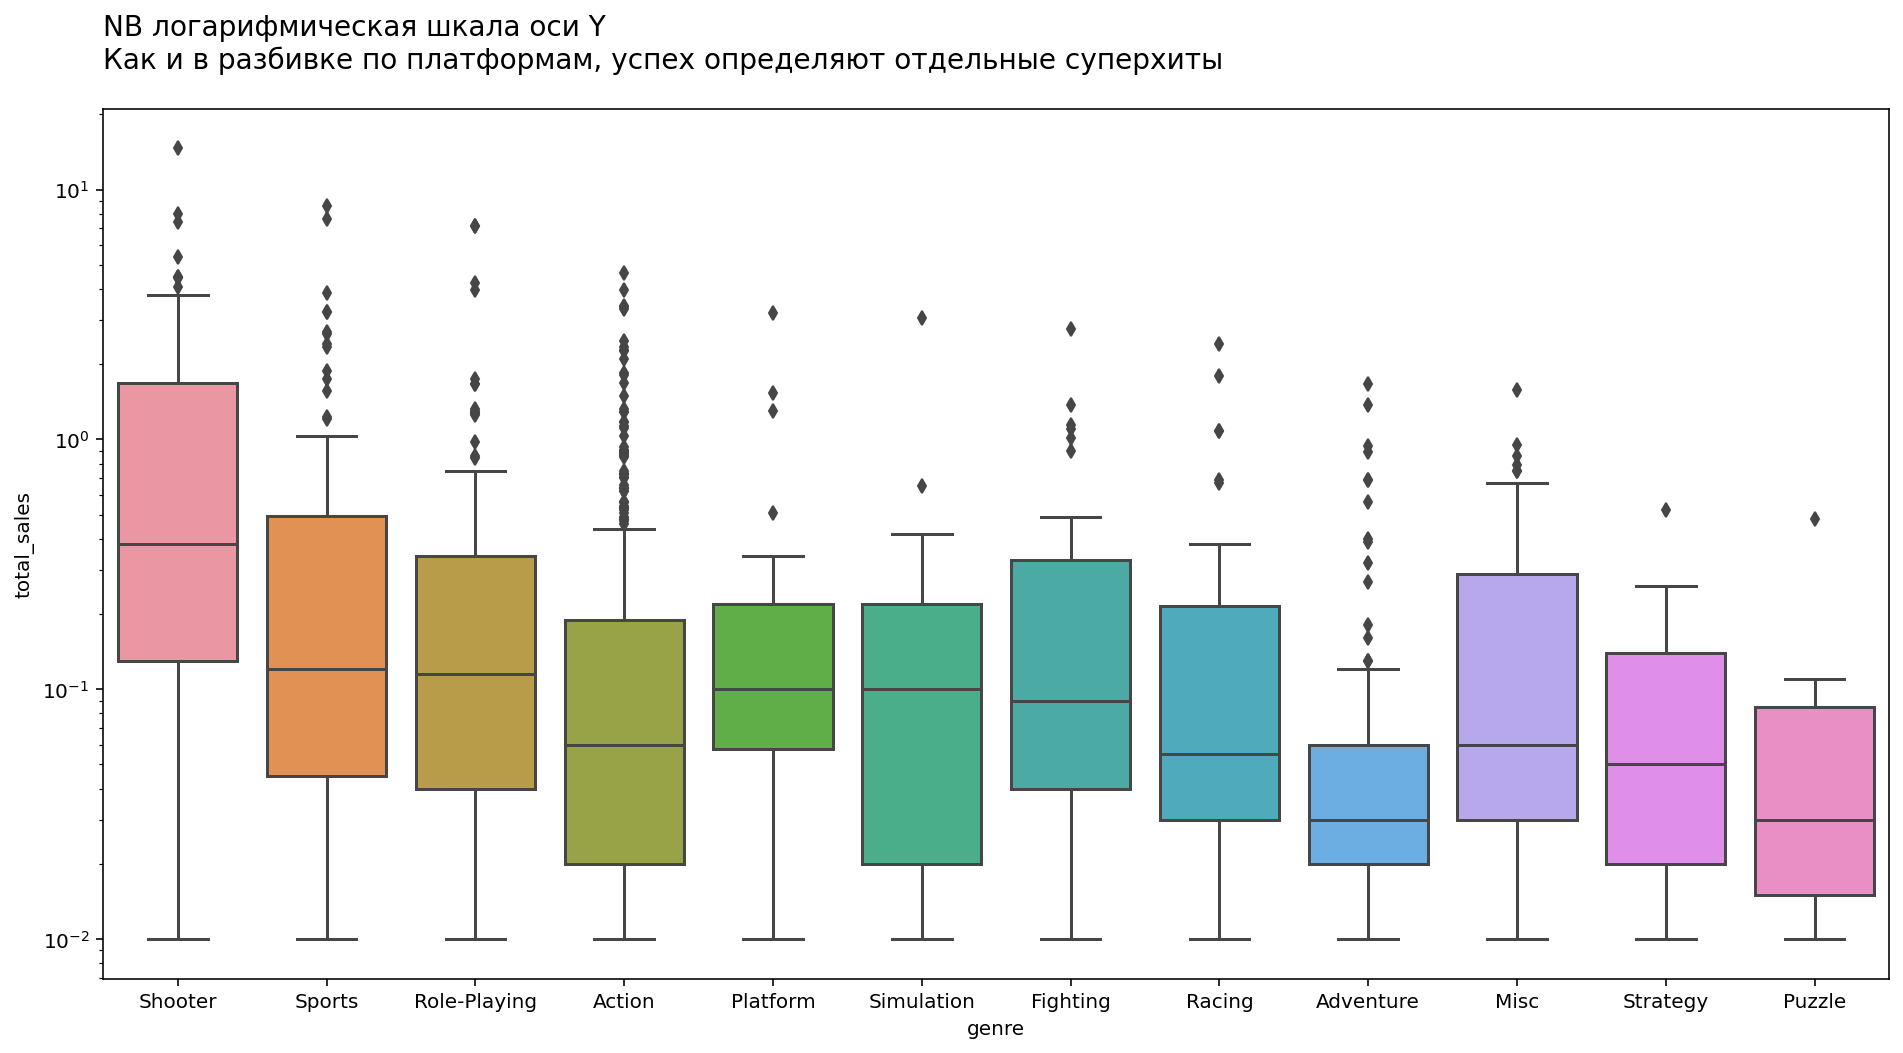

In [38]:
plt.figure(figsize=(16,8))
sns.boxplot(x="genre",
            y="total_sales", 
            data=data.query('year_of_release > 2014'))
plt.yscale('log')
plt.title('NB логарифмическая шкала оси Y \nКак и в разбивке по платформам, успех определяют отдельные суперхиты', loc='left', pad=20, fontsize=14)
;

In [39]:
genres = (
    data.query('year_of_release > 2014')
    .groupby('genre').agg({'total_sales' : ('median', 'sum', 'max'), 'name' : 'count'})
    .sort_values(by=('total_sales', 'max'), ascending=False)

    )
display (genres.style.bar(color='plum', vmin=0))

In [40]:
genres = genres.reset_index()
genres.columns=[' '.join(col).strip() for col in genres.columns.values]

In [41]:
print('Размер круга - медиана продаж')
print('Цвет круга - максимальные продажи по одной игре')

fig = px.scatter(
    genres, 
    x='name count', y='total_sales sum',
    size='total_sales median', color = 'total_sales max', text='genre', trendline="ols",
    color_continuous_scale=px.colors.sequential.Plasma,
    title = 'Размер круга - медиана продаж, цвет круга - максимальные продажи по одной игре')

fig.show()

Размер круга - медиана продаж
Цвет круга - максимальные продажи по одной игре


ВЫВОД: 
- По количеству продаж лидируют Action, но их и выпущено больше всех. Далее - Role-Playing, Sports и Shooter, они **лучше среднего по соотношению количество проданных копий игр / количество выпущенных игр**
- По медиане количества продаж лидер Shooter, с большим отрывом
- Максимальные продажи на одну игру также в категории Shooter, с большим отрывом
- у Shooter, Sports, Role-playing показатели по соотношению количество продаж / количество выпущенных копий выше среднего, у остальных - ниже
- Прибыльность оценить не получится, так как нет данных по продажам в денежном выражении и себестоимости

### Выводы по исследовательскому анализу:
- Данные не очень хорошего качества, много пробелов в поле рейтинг, оценка пользователей, оценка критиков.
- Данные до 2000 года можем не учитывать при построении прогнозов.
- **Прибыльность оценить не получится, так как нет данных по продажам в денежном выражении и себестоимости**
---
ПЛАТФОРМЫ:
- платформы как правило выходят на пик за 3 - 5 лет
- в целом продажи в имеющемся наборе данных замедляются
- явных лидеров нет
- в активном пуле на следующий год можно оставить PS4, PC, PSV, Wii:
    - в предыдущие годы некоторые платформы показывали паттерн "отскока" - достигали пика, резко падали, достигали второго пика и падали окончательно. Такой отскок происходил только в случае если первое падение не достигало изначального минимума продаж. Из имеющихся платформ такой паттерн еще может показать PS4
    - есть небольшие, но стабильные уже много лет платформы PC и PSV. Они скорее всего не покажут резкого роста, но и особо не просядут.
    - Wii явно прошла пик, но также стабилизировалась, можно оставить в пуле.
    - Остальные платформы скорее всего сходят с дистанции
---
ЖАНРЫ
- По количеству продаж лидируют Action, но их и выпущено больше всех. Далее - Role-Playing, Sports и Shooter, они лучше среднего по соотношению количество проданных копий игр / количество выпущенных игр
- По медиане количества продаж лидер Shooter, с большим отрывом
- Максимальные продажи на одну игру также в категории Shooter, с большим отрывом
- у Shooter, Sports, Role-playing показатели по соотношению количество продаж / количество выпущенных копий выше среднего, у остальных - ниже

- Прибыльнось оценить не получится, так как нет данных по продажам в денежном выражении и себестоимости

---
ОСОБЕННОСТИ ПРОДАЖ
- **Большинство игр продаются слабо, но у многих платформ есть отдельные хиты и суперхиты**
- хиты часто получают более высокие оценки критиков (от 60 и выше)
- оценки пользователей слабее коррелируют с супер-успехом игры
- есть положительная корреляция между оценками критиков и оценками пользователей

## Составьте портрет пользователя каждого региона

### Задание: Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

#### Популярность платформ

определю функцию для построения графиков продаж по платформам, в разбивке по дополнительному параметру, в деньгах и нормализованные (100%)

In [42]:
def show_pct(feature):
# функция строит stacked bar plot для территории с разбивкой по feature, в денежном и процентном выражении
    # сформируем датафрейм с разбивкой в денежном выражении
    df = (
        data.query('year_of_release > 2014').groupby(feature)
        [['na_sales', 'eu_sales','jp_sales']].sum()
        .sort_values(by='na_sales', ascending=False).T
    )

    #сформируем датафрейм с процентным соотношением показателей для каждой территории
    # поделим каждый ряд на сумму значений ряда, чтобы получить в сумму 100%
    df_pct=df.apply(lambda x: x/x.sum(), axis=1)
    df_pct.plot(kind='barh', stacked=True, figsize=(12,5))

    plt.grid(visible=True, axis='x')
    plt.title(f'разбивка {feature} по территориям в процентах', fontsize=15, loc='left', pad=20)
    plt.legend(bbox_to_anchor=(1.1, 1));
    
    # покажем топ-5 популярных feature по каждой территории
    print('---------------------------------------')
    print(f'доля популярных {feature} по территориям: ')
    print('---------------------------------------')

    for i in df_pct.index:
        
        display(
            df_pct.loc[i]
            .sort_values(ascending=False)
            .reset_index()
            .head(5)
            .style.bar(vmin=0, color='lavender')
            
            )

---------------------------------------
доля популярных platform по территориям: 
---------------------------------------


---------------------------------------
доля популярных genre по территориям: 
---------------------------------------


---------------------------------------
доля популярных rating по территориям: 
---------------------------------------


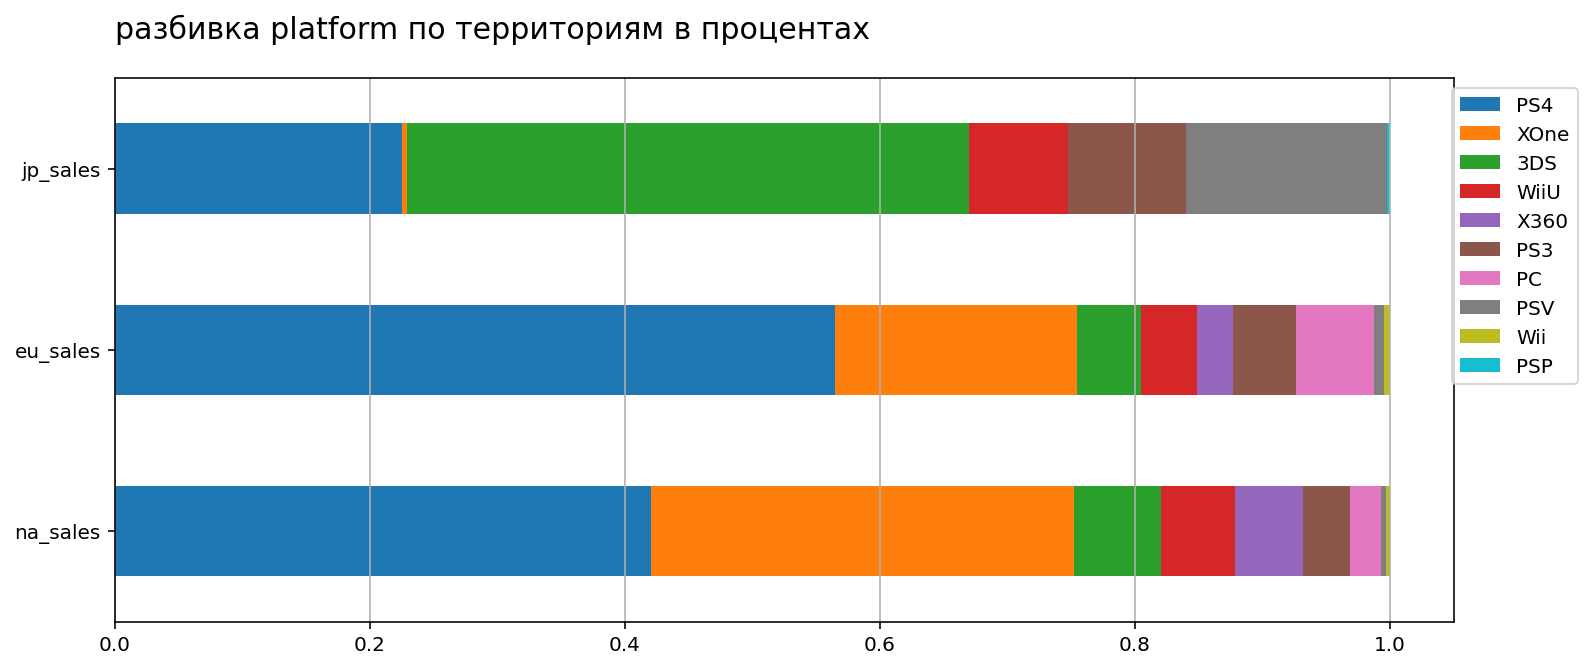

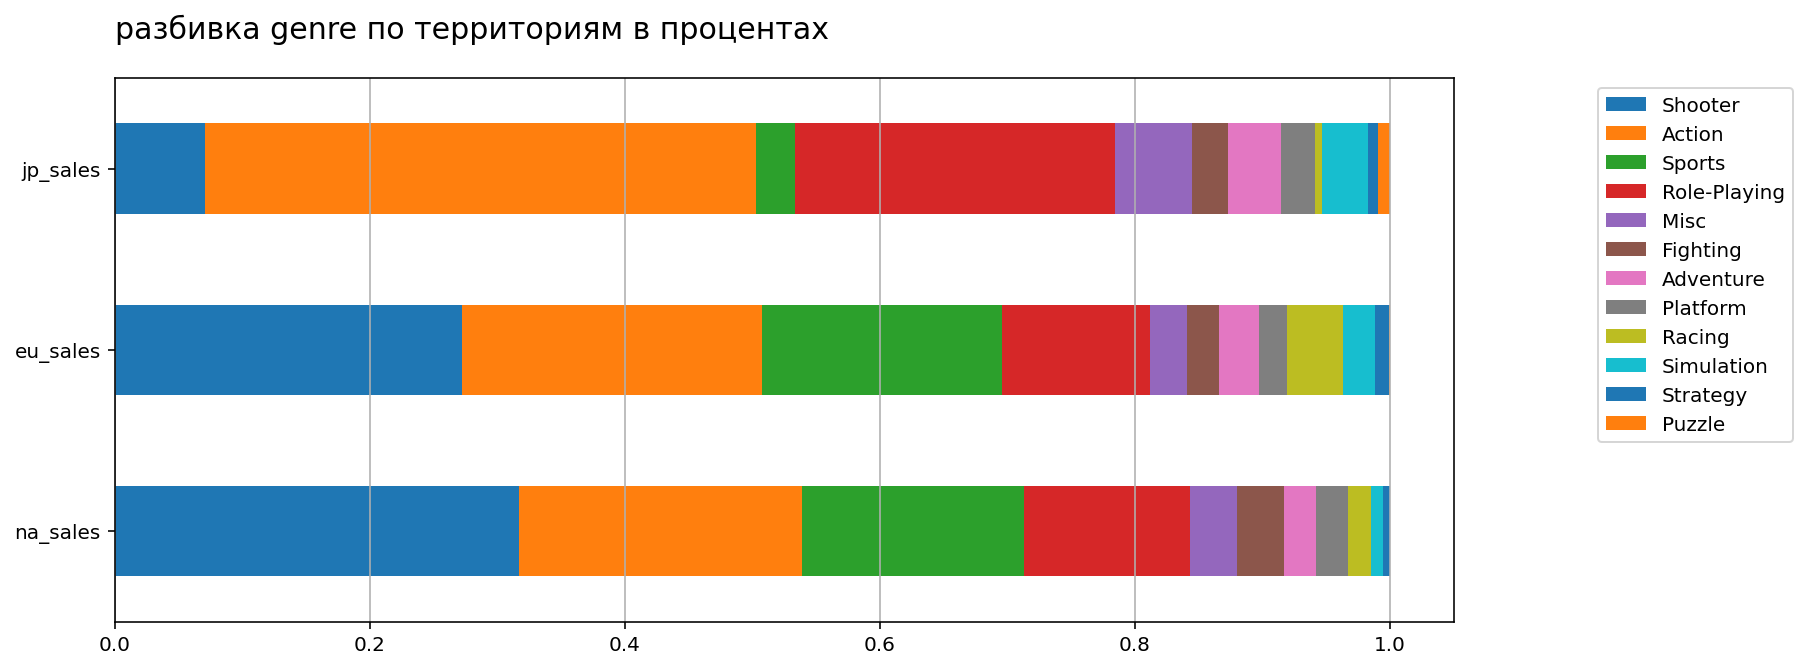

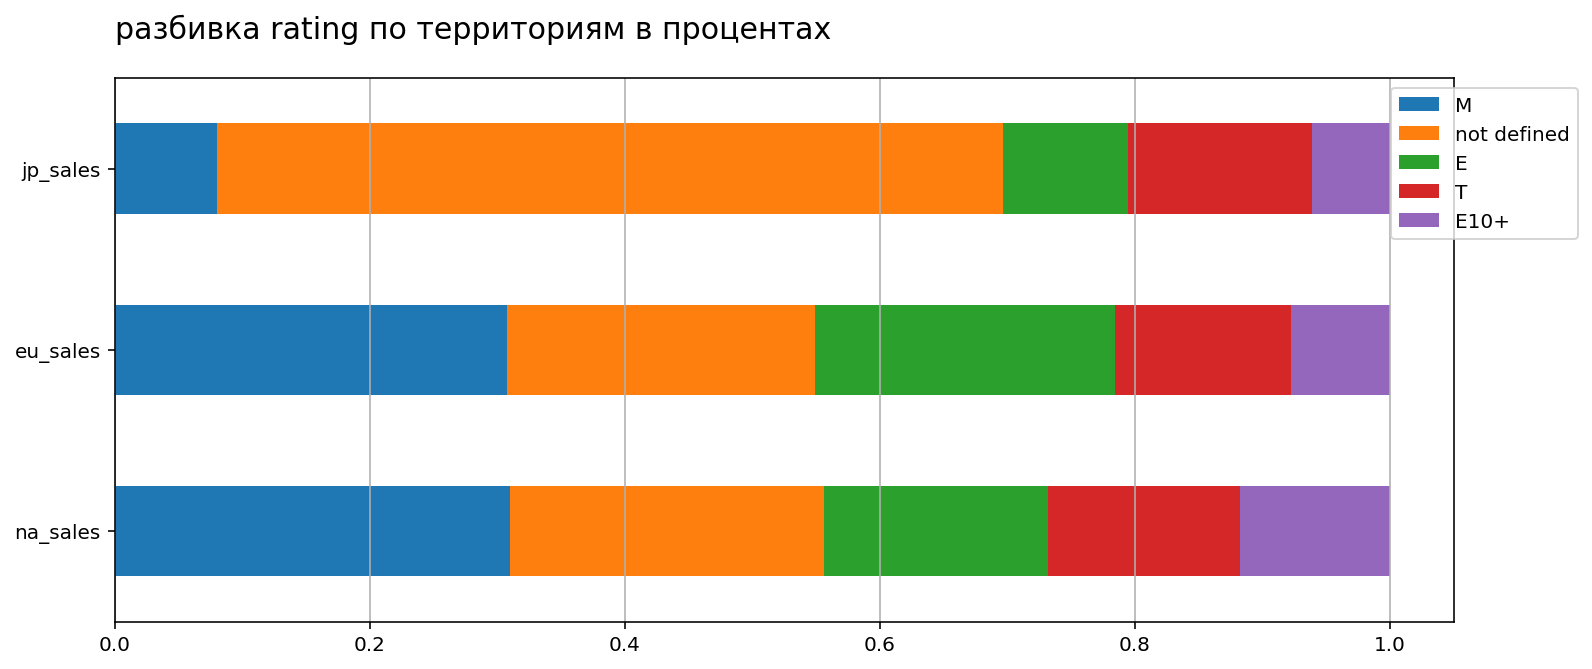

In [43]:
for i in ['platform', 'genre', 'rating']:
    show_pct(i)

In [44]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales'],
      dtype='object')

''

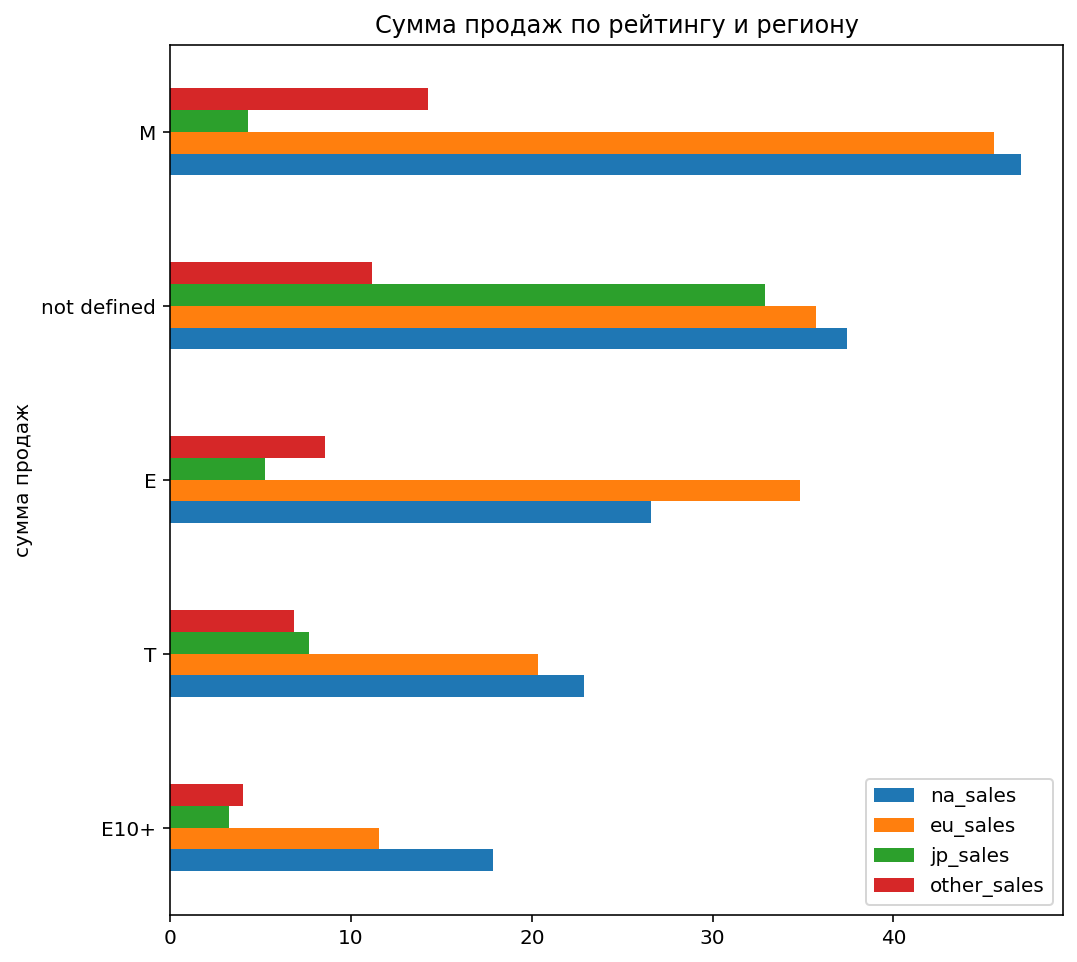

In [45]:
rtn = (data
 .query('year_of_release > 2014')
 .groupby('rating')[['na_sales', 'eu_sales','jp_sales', 'other_sales']]
 .sum().sort_values(by='na_sales')
       )       
# rtn.plot(figsize=(16,4), ylabel="сумма продаж")
rtn.plot(figsize=(8,8), kind='barh', xlabel='сумма продаж', title='Сумма продаж по рейтингу и региону')
# plt.ylabel('сумма продаж')
;

### ВЫВОД: 
топ-5 за период с 2000 года по платформам, рейтингам и жанрам похож в Северной Америке и Европе и существенно отличается в Японии.

Лидеры в Японии - платформа DS, игры жанра Role-playing, оба не входят в топ-3 Европы/Северной Америки, где лидируют PS2/PS3/X360 и Action/Sports/Shooter

По рейтингам нет принципиальной разницы

## Задание: Проверьте гипотезы

ДОПУЩЕНИЕ:

буду интерпретировать представленный набор данных как выборку из популяции (часть людей из всех людей, которые в принципе играют в представленные игры). Если интерпретировать имеющийся набор данных как полный набор, можно было бы просто посчитать среднее, так как набор небольшой.

Так как обе гипотеы это двусторонняя проверка равенства средних выборок из генеральной совокупности, мы можем использовать для проверки один метод st.ttest_ind.  

Определю функцию:

In [47]:
# функция принимает название поля, два значения поля для группировки и alpha для статистического теста равенства среднего
# выборок из генеральной совокупности,
# генерирует series для сравнения и выдает результат сравнения

def mean_diff(feature, f1, f2, alpha):
    f1_score = data.loc[(data[feature] == f1) & (data['user_score'] > 0)]['user_score']
    f2_score = data.loc[(data[feature] == f2) & (data['user_score'] > 0)]['user_score']

    print(f'Средние значения пользовательских рейтингов, \nby {feature.upper()}:')
    print ('    ',f1, f1_score.mean())
    print ('    ',f2, f2_score.mean())   
    
    p_value = st.ttest_ind (f1_score, f2_score)[1]

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между средними выборок есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать средние выборок разными'
        )


#### Гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем нулевую и альтернативную гипотезы:

H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H1: Средние пользовательские рейтинги платформ Xbox One и PC отличаются

In [48]:
mean_diff('platform', 'PC', 'XOne', 0.01)

Средние значения пользовательских рейтингов, 
by PLATFORM:
     PC 7.0340599455040875
     XOne 6.521428571428572
p-значение:  3.750185722417337e-05
Отвергаем нулевую гипотезу: между средними выборок есть значимая разница


**ВЫВОД: разница между средними пользовательскими рейтингами платформ Xbox One и PC небольшая, но статистически значимая даже при alpha = 0.01**

#### Гипотеза 2: Средние пользовательские рейтинги жанров Action и Sports разные

Сформулируем нулевую и альтернативную гипотезы:

H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые

H1: Средние пользовательские рейтинги жанров Action и Sports отличаются

In [49]:
mean_diff('genre', 'Action', 'Sports', 0.05)

Средние значения пользовательских рейтингов, 
by GENRE:
     Action 7.045648512071869
     Sports 6.94772937905468
p-значение:  0.09063548503578989
Не получилось отвергнуть нулевую гипотезу, нет оснований считать средние выборок разными


**ВЫВОД: разница между средними пользовательскими рейтингами жанров Action и Sports не является статистически значимой**.

## Что определяет успех игры?

### Допущения и ограничения:

- мы уже определили, что рынки Северной Америки и Европы похожи, а Япония сильно отличается. Поэтому анализ для этих групп нужно делать отдельно. Для примера проанализирую Америку + Европу, так как они составляют бОльшую часть рынка.
- как определили ранее, данные до 2000 года можно не учитывать в анализе
- также как определили ранее, успех продаж в целом определяется наиболее успешными играми, "хитами". Поэтому предположу, что она из ключевых задач планирования - определить, какие игры потенциально могут стать хитами.

Подготовим набор данных - оставим данные по Европе и Америке после 2000 года

In [50]:
data_ae = ( 
    data
    .assign(ae_sales = lambda x: x['na_sales'] + x['eu_sales'])
    .query('year_of_release > 2000 and ae_sales > 0')
    .drop(['na_sales', 'eu_sales','jp_sales', 'other_sales', 'total_sales'], axis=1)
)

data_ae

name platform  year_of_release  \
0                              Wii Sports      Wii             2006   
2                          Mario Kart Wii      Wii             2008   
3                       Wii Sports Resort      Wii             2009   
6                   New Super Mario Bros.       DS             2006   
7                                Wii Play      Wii             2006   
...                                   ...      ...              ...   
16705                             15 Days       PC             2009   
16706       Men in Black II: Alien Escape       GC             2003   
16708  Woody Woodpecker in Crazy Castle 5      GBA             2002   
16711                    LMA Manager 2007     X360             2006   
16713                    Spirits & Spells      GBA             2003   

           genre  critic_score  user_score       rating  ae_sales  
0         Sports          76.0         8.0            E     70.32  
2         Racing          82.0         8.3            E     28.44  
3         Sports          80.0         8.0            E     26.54  
6       Platform          89.0         8.5            E     20.42  
7           Misc          58.0         6.6            E     23.14  
...          ...           ...         ...          ...       ...  
16705  Adventure          63.0         5.8  not defined      0.01  
16706    Shooter           0.0         0.0            T      0.01  
16708   Platform           0.0         0.0  not defined      0.01  
16711     Sports           0.0         0.0  not defined      0.01  
16713   Platform           0.0         0.0  not defined      0.01  

[11505 rows x 8 columns]

### Хиты: сформулируем, что считаем хитом и разметим их в наборе данных

ae_sales  share_sales
99   1069.35         0.20
98   1506.50         0.28
97   1833.42         0.34
96   2095.90         0.38
95   2313.59         0.42
94   2510.33         0.46
93   2673.47         0.49
92   2830.67         0.52
91   2962.23         0.54
90   3101.48         0.57

''

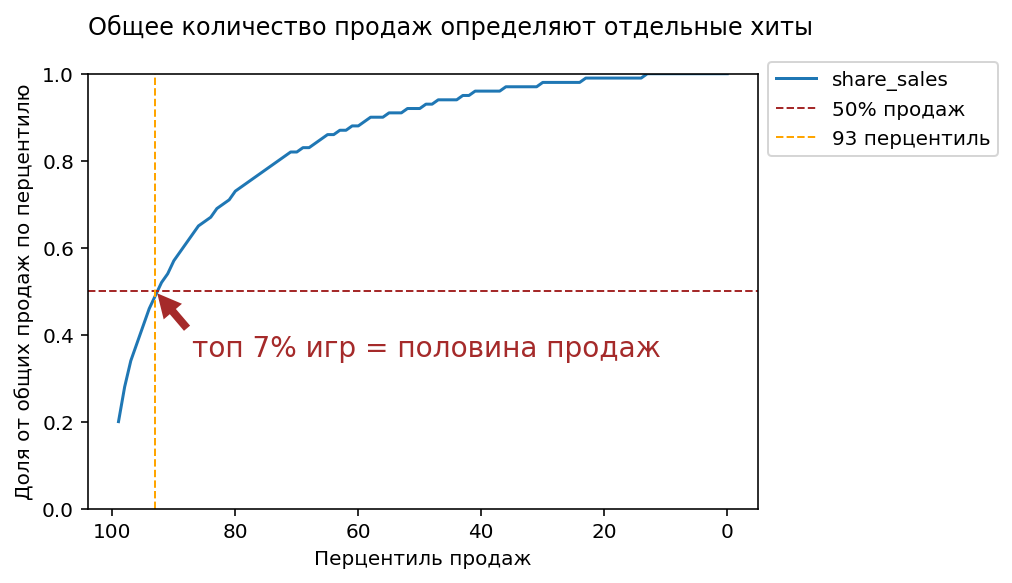

In [51]:
#общая сумма продаж
total_sales = data_ae['ae_sales'].sum()

# словарь перцентиль по продажам - сумма продаж на это перцентиль И БОЛЬШЕ
# т.к. хотим показать долю СВЕРХУ этого перцентиля
pct_sales = {}

for i in range(0,100):
    pct = data_ae.loc[data_ae['ae_sales']>=data_ae['ae_sales'].quantile(i/100), ['ae_sales']].sum()
    pct_sales[i] = pct
    
# датафрейм с добавленной долей продаж, соответствующей перцентилю
pct_sales = (
    pd.DataFrame(pct_sales).T.sort_index(ascending=False) 
    .assign(share_sales = lambda x: (x['ae_sales'] / total_sales).round(2))
)

display (pct_sales.head(10) )

pct_sales['share_sales'].plot()
plt.gca().invert_xaxis()
plt.ylim(0,1)
plt.axhline(y=0.5, color='brown', label='50% продаж', linestyle='--', linewidth=1)
plt.axvline(x=93, color='orange', label='93 перцентиль', linestyle='--', linewidth=1)
plt.annotate('топ 7% игр = половина продаж', xy=(93, 0.5), xytext=(87,0.35), c='brown', size=14,
            arrowprops=dict(facecolor='brown', ec='None', shrink=0.05)
            )
plt.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel('Перцентиль продаж')
plt.ylabel('Доля от общих продаж по перцентилю')
plt.title('Общее количество продаж определяют отдельные хиты', loc='left', pad=20)
;


Разметим верхние 7% как хиты

In [52]:
# установим лимит, 93 перцентиль
hit_thresh = data_ae['ae_sales'].quantile(0.93)

data_ae['is_hit'] = data_ae['ae_sales'].apply(lambda x: 1 if x >= hit_thresh else 0)
data_ae.head()

name platform  year_of_release     genre  critic_score  \
0             Wii Sports      Wii             2006    Sports          76.0   
2         Mario Kart Wii      Wii             2008    Racing          82.0   
3      Wii Sports Resort      Wii             2009    Sports          80.0   
6  New Super Mario Bros.       DS             2006  Platform          89.0   
7               Wii Play      Wii             2006      Misc          58.0   

   user_score rating  ae_sales  is_hit  
0         8.0      E     70.32       1  
2         8.3      E     28.44       1  
3         8.0      E     26.54       1  
6         8.5      E     20.42       1  
7         6.6      E     23.14       1

### Кластеризация
#### Подготовка данных

Чтобы сформулировать, что определяет успех игры, воспользуемся методами машинного обучения, а именно кластеризацией данных.
Не все признаки в наборе данных нам пригодятся. Оставим только 'genre', 'critic_score', 'user_score', 'rating'. Целевая переменная = 'is_hit'.

In [53]:
data_cluster = data_ae.drop(['name', 'platform', 'year_of_release', 'ae_sales'], axis=1)
data_cluster.sample(5)

genre  critic_score  user_score       rating  is_hit
8599      Action          50.0         5.7            E       0
14363  Adventure           0.0         0.0  not defined       0
5023      Racing          53.0         8.2            E       0
5420    Fighting           0.0         0.0  not defined       0
2370      Action          61.0         5.5            T       0

17% полученного набора данных не содержит информации по всем трем признакам. Отброшу их.

In [54]:
no_data = data_cluster.query('rating.isna() and critic_score == 0 and user_score == 0').shape[0]
no_data_share = no_data / data_cluster.shape[0]
no_data_share

0.0

Отброшу бесполезные записи. Заметим, что хитов по-прежнему осталось порядка 7%.

In [55]:
data_cluster = data_cluster.query('not (rating.isna() and critic_score == 0 and user_score == 0)')
print("Осталось записей", data_cluster.shape[0] )

print ("Доля хитов", data_cluster['is_hit'].mean())

Осталось записей 11505
Доля хитов 0.0702303346371143


Приведу категориальные переменные rating, genre  к числовому виду

In [56]:
encoder =  LabelEncoder() # создаём переменную класса LabelEncoder - кодировщик
for i in ['rating', 'genre']:
    data_cluster[i+'_st'] = encoder.fit_transform(data_cluster[i]) # используем кодировщик, чтобы "перевести" строковые названия в числа


      

Качество данных не самое лучшее (по-прежнему много пропусков), но для демонстрационных целей достаточное

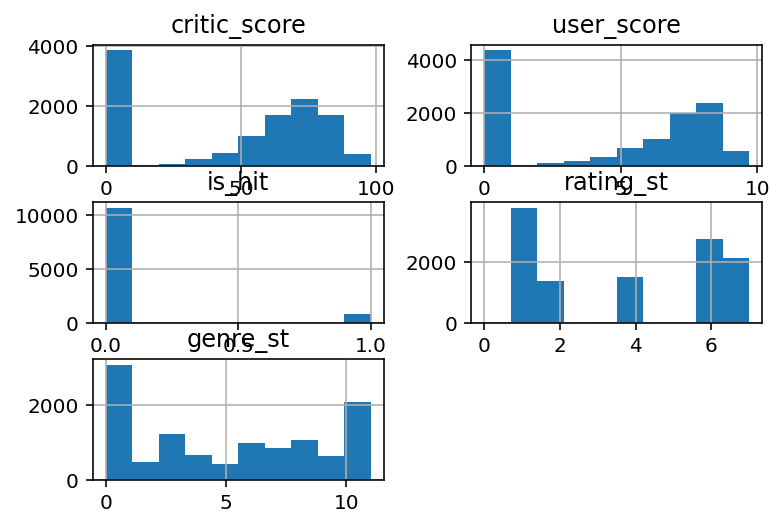

In [57]:
data_cluster.hist();

Так как я собираюсь использовать методы, чувствительные к расстояниям, стандартизирую признаки

In [58]:
X = data_cluster.drop(['is_hit', 'rating', 'genre'], axis=1)
y = data_cluster['is_hit']

In [59]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

# сохраним получившуюся стандартизированную таблицу для использования в дендрограмме
linked = linkage(X_sc, method = 'ward') 

#### Определим количество кластеров в данных, отрисовав дендрограмму.

In [60]:
# plt.figure(figsize=(15, 10))  
# dendrogram(linked, orientation='top')
# plt.title('Иерархическая кластеризация для игр')
# plt.show();

Выделились два кластера. Для того, чтобы не тормозить обработку тетради, закомментирую код и сохраню дендрограмму как рисунок.

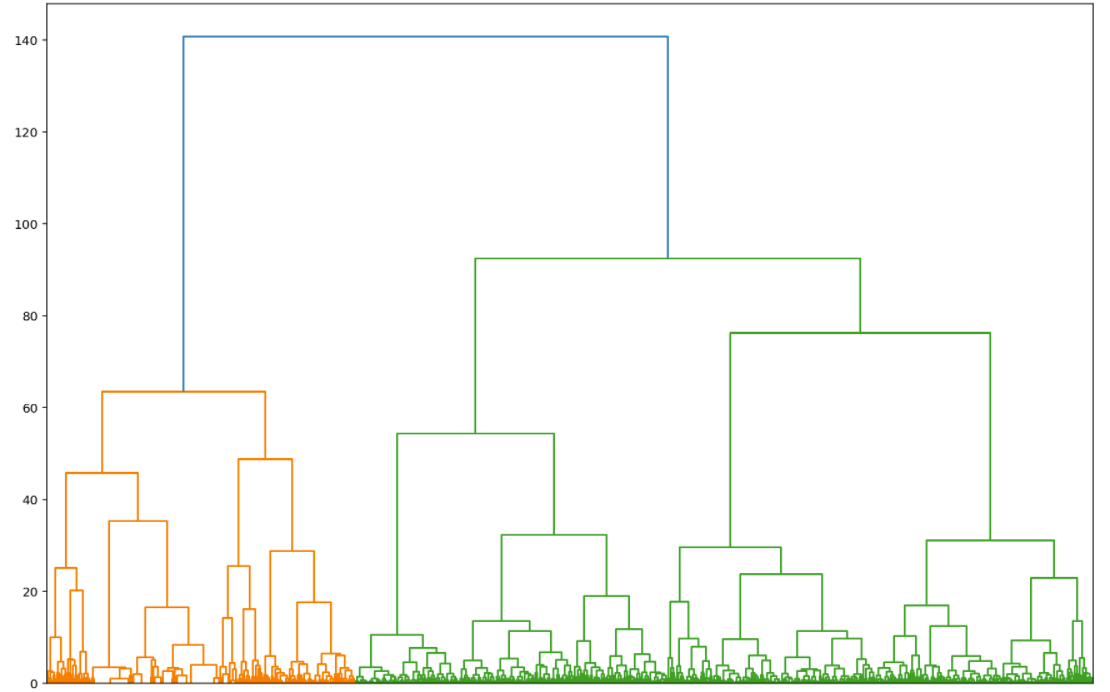

#### Вычислив количество кластеров, можем применить метод K-means, чтобы выделить кластеры

In [61]:
# задаём число кластеров и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=2, random_state=0) 
# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc) 

In [62]:
# сохраняем метки кластера в поле нашего датасета
data_cluster['cluster'] = labels

In [63]:
data_cluster.sample(5)

genre  critic_score  user_score rating  is_hit  rating_st  genre_st  \
81     Action          88.0         6.6      E       1          1         0   
590    Sports          84.0         8.1      E       1          1        10   
8109   Sports          38.0         7.9      E       0          1        10   
4884   Sports          71.0         5.7      E       0          1        10   
13320  Sports          60.0         0.0      E       0          1        10   

       cluster  
81           0  
590          0  
8109         0  
4884         0  
13320        1

#### Описание кластеров

Посмотрим, есть ли явные различия в средних признаках кластеров. Пока можно сказать, что 
- у игр с высокой оценкой пользователей и критиков в 10 раз выше шансы быть блокбастерами. Не революционно, но хотя бы логично.
- отбросив 30% игр с низкими рейтингами мы в 10 раз повышаем вероятность угадать хит

In [64]:
display (
    data_cluster.groupby(['cluster'])
    .mean()
    .style.bar(color='pink', vmin=0)

)

In [65]:
data_cluster['cluster'].value_counts()

0    6871
1    4634
Name: cluster, dtype: int64

#### Отрисуем попарное сочетание признаков с разметкой по кластерам

In [66]:
data_cluster.drop(['rating_st','genre_st', 'cluster'], axis=1).columns

Index(['genre', 'critic_score', 'user_score', 'rating', 'is_hit'], dtype='object')

In [67]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def clusters_scatter (df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=df[x_name], y=df[y_name], hue=df[cluster_name], palette={0:'navy', 1:'orange'}, alpha=0.5
    )
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show();

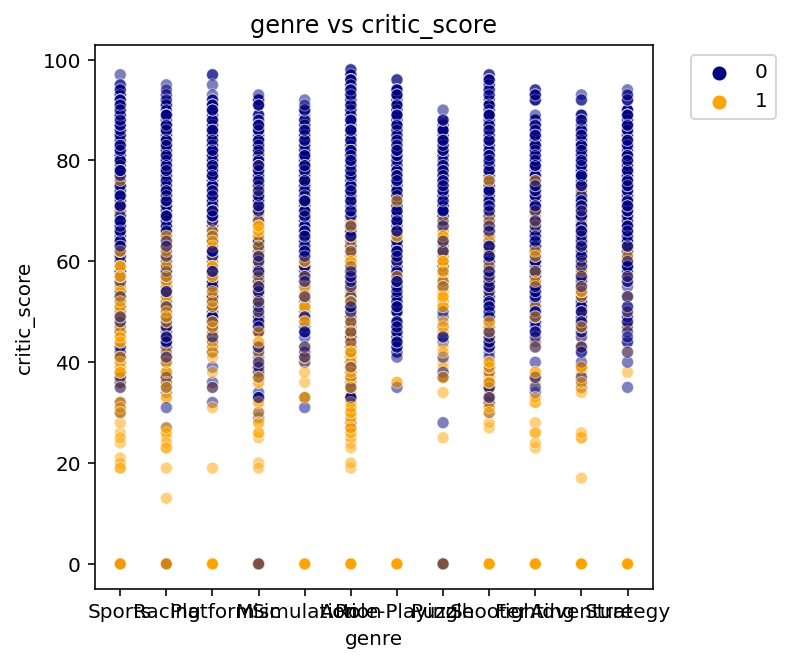

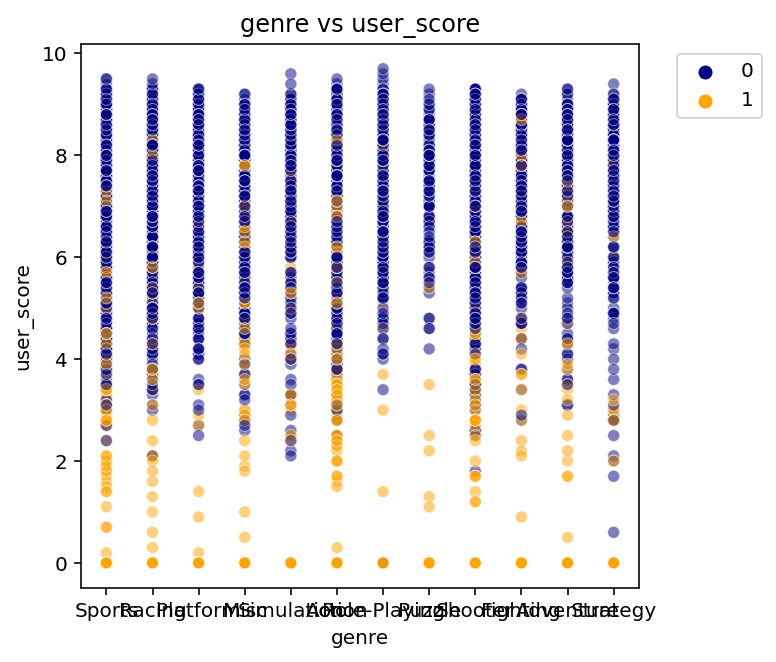

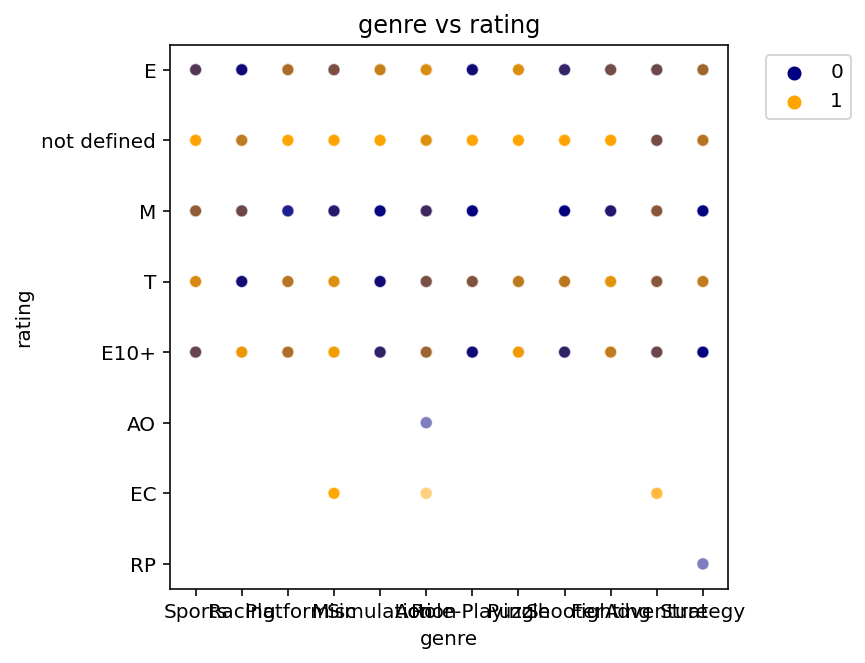

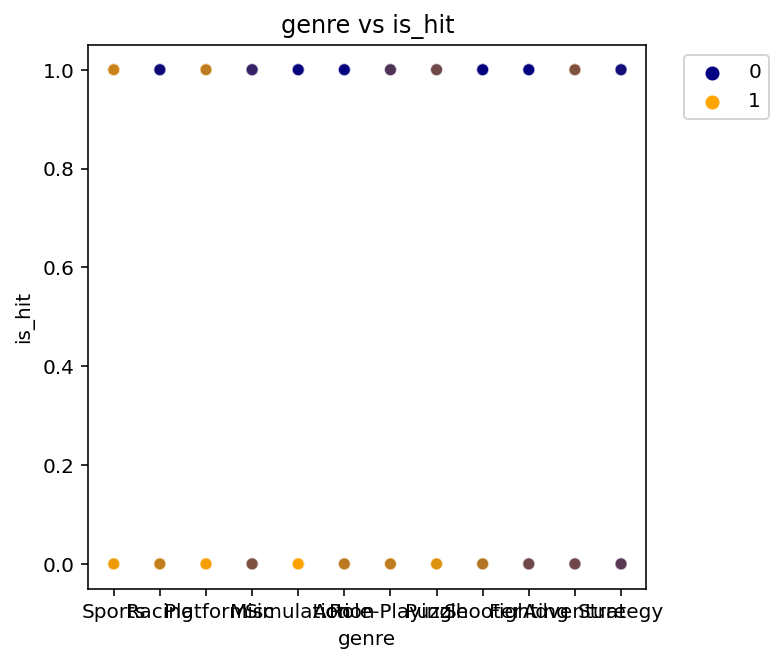

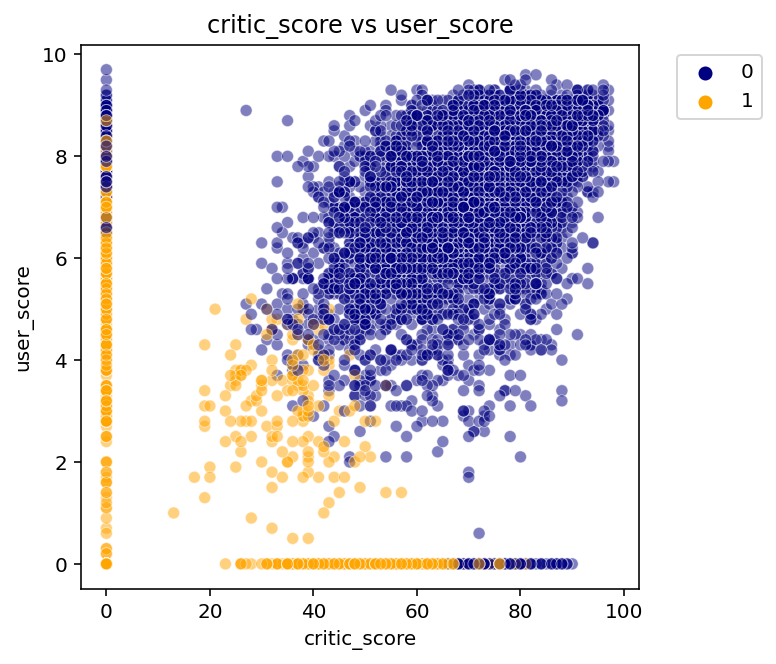

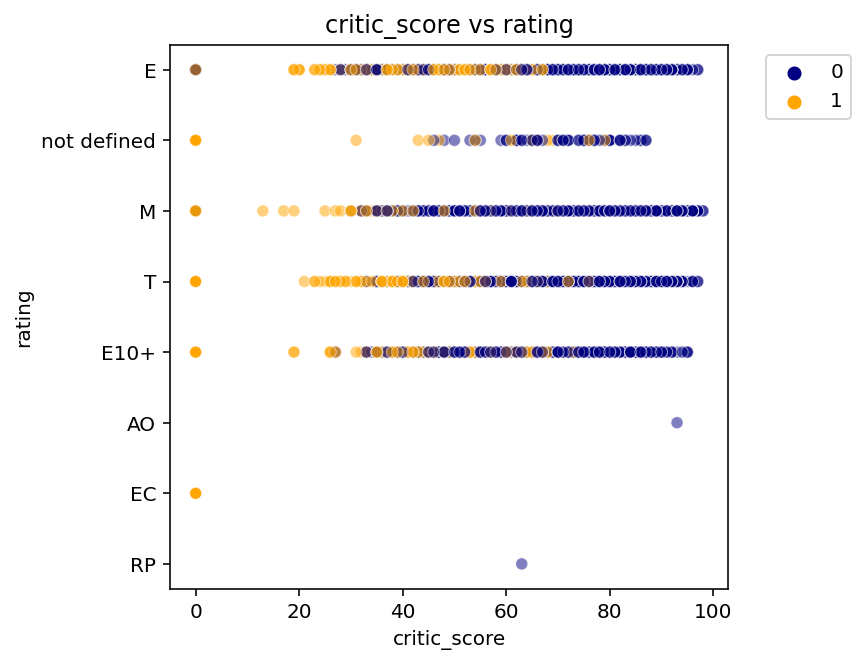

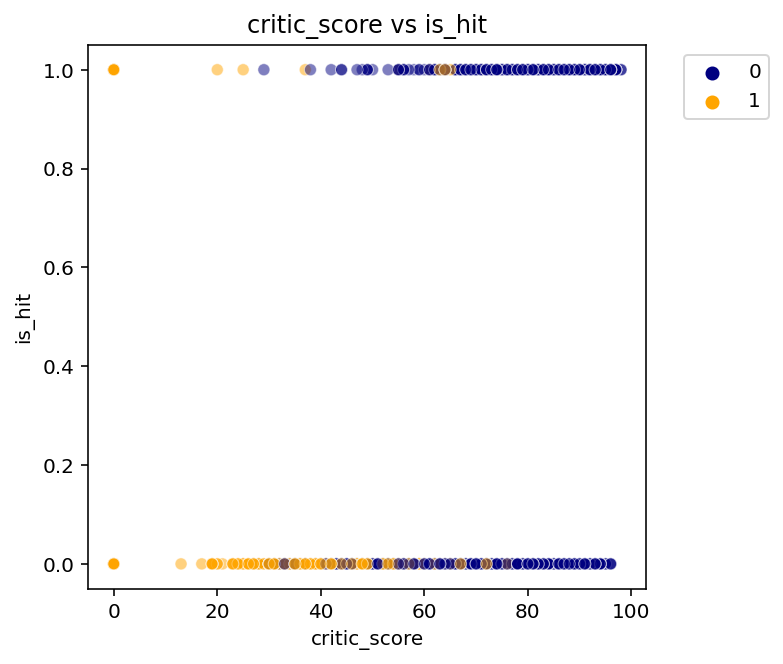

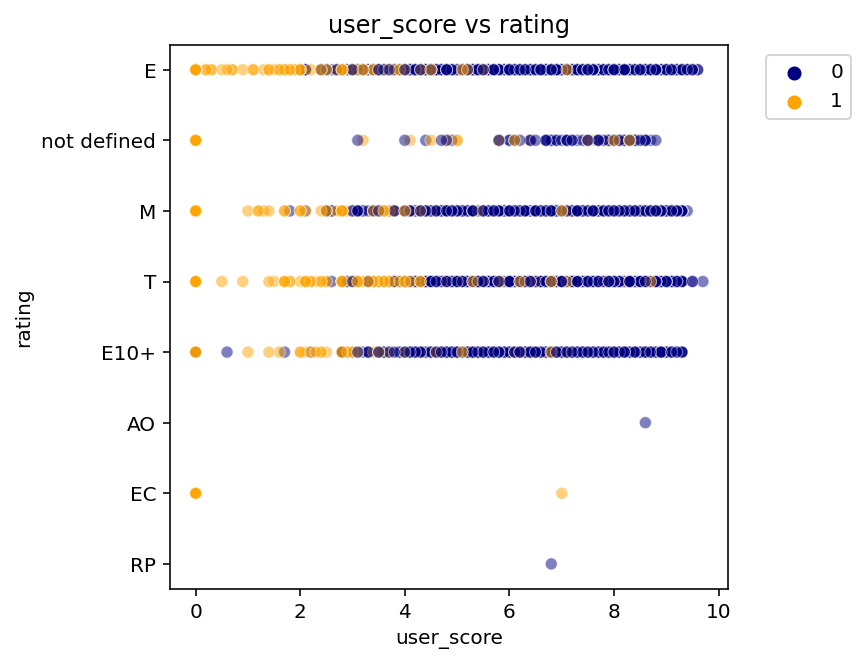

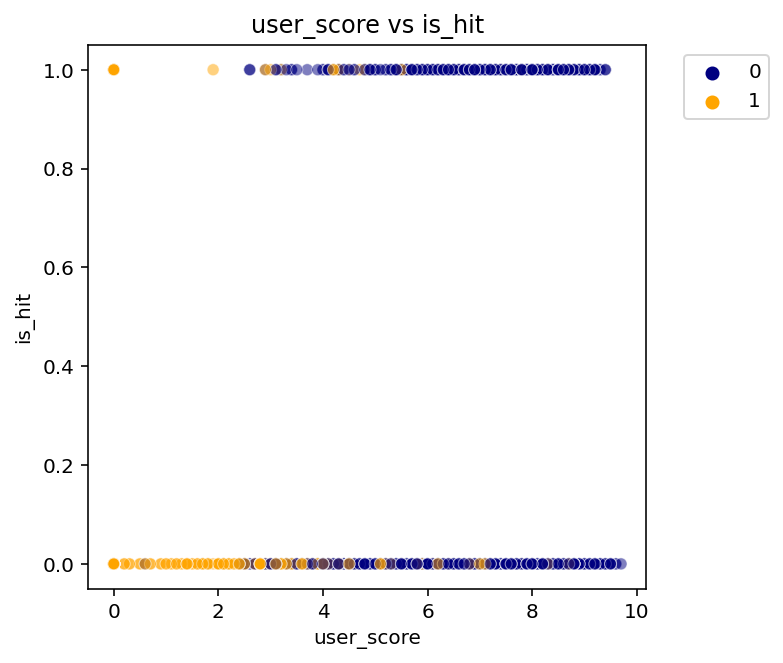

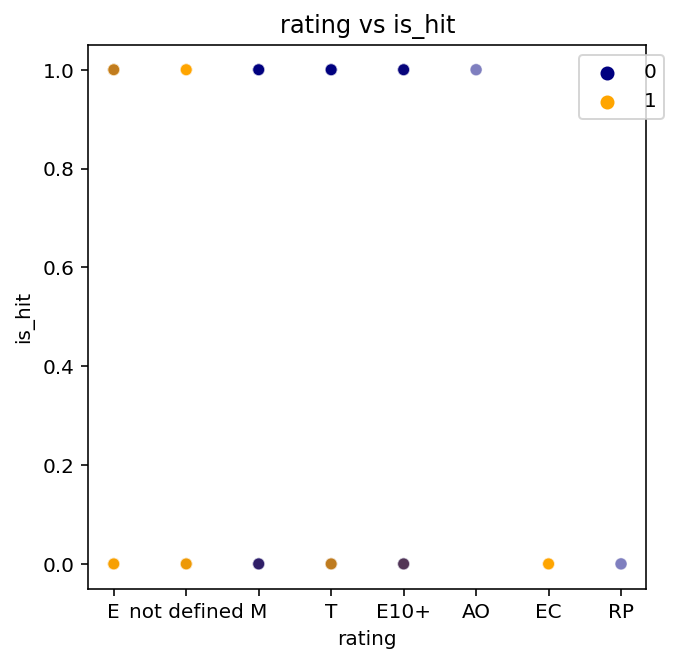

In [68]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(data_cluster.drop(['rating_st','genre_st', 'cluster'], axis=1).columns, 2))
for pair in col_pairs:
    clusters_scatter (data_cluster, pair[0], pair[1], 'cluster')


ВЫВОДЫ: 
- основной фактор кластеризации - высокая оценка зрителей и критиков
- также наблюдаем корреляцию с некоторыми рейтингами и жанрами

#### Построим распределение признаков для кластеров

In [69]:
data_cluster['critic_score'].value_counts().head(5).index

Float64Index([0.0, 70.0, 71.0, 75.0, 73.0], dtype='float64')

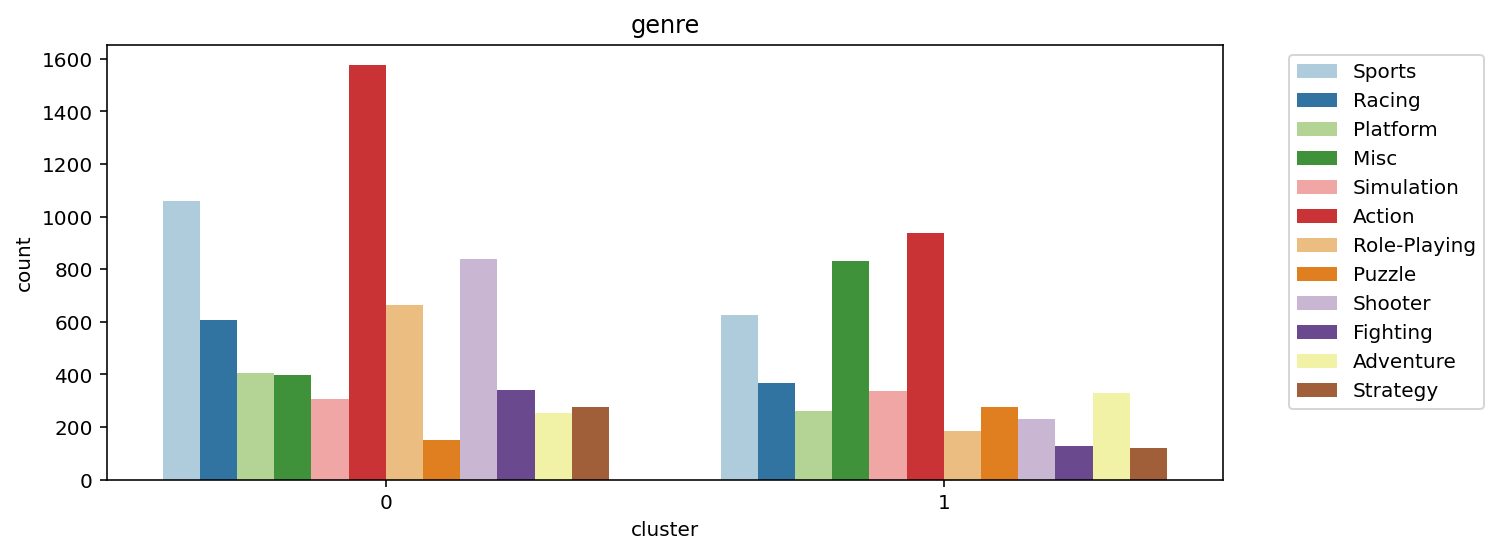

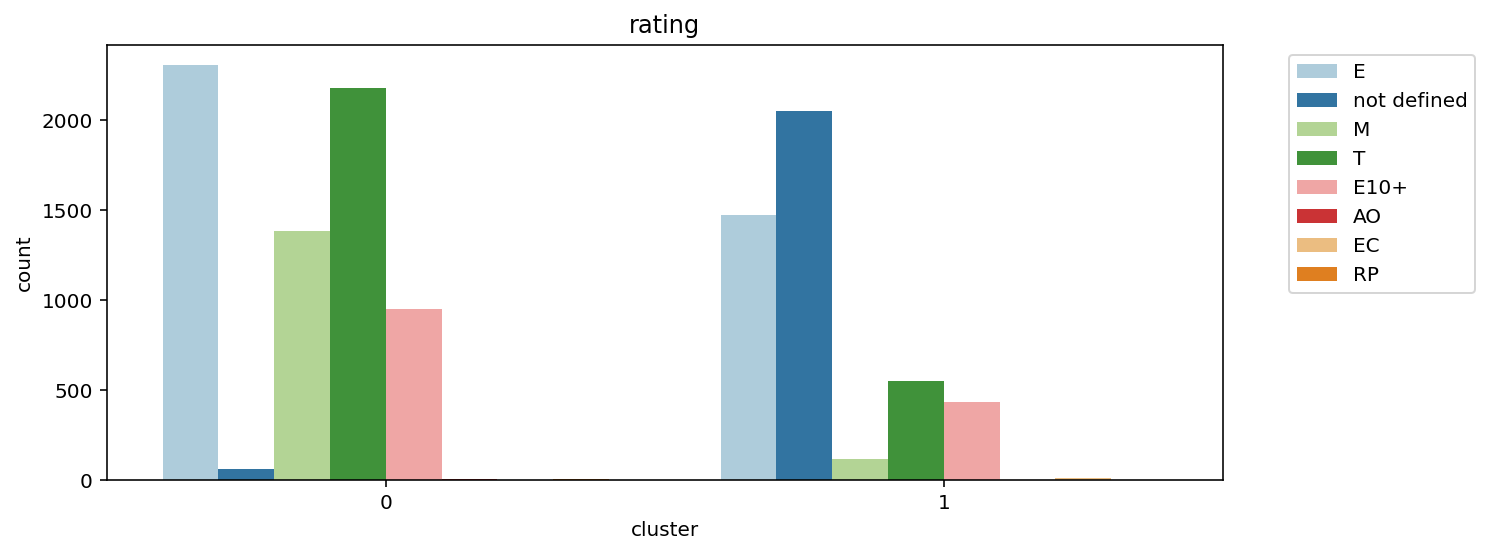

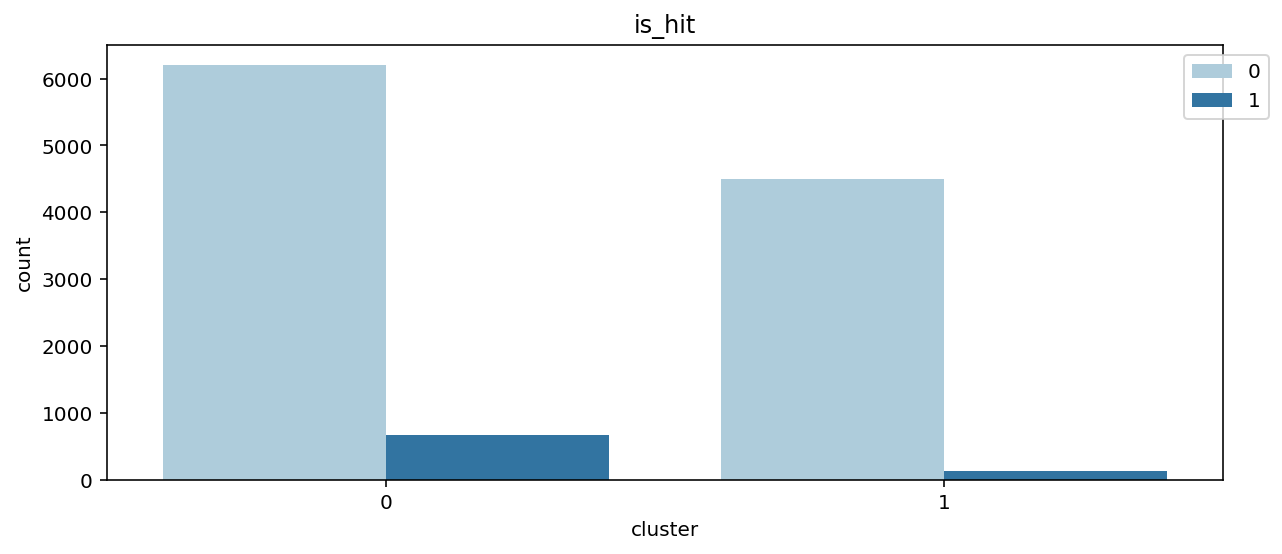

In [70]:
for column in ['genre', 'rating', 'is_hit']:
    plt.figure(figsize=(10,4)) 
    plt.title(column) 
    sns.countplot(data = data_cluster, x = 'cluster', hue = column, palette='Paired')
    plt.legend(bbox_to_anchor=(1.05, 1))
    ;

#### ВЫВОДЫ: 

ДОПУЩЕНИЕ: не буду отбрасывать данные до 2000 года, так как данных и так мало и они в любом случае низкого качества + цифры за 2016 год неполные.

NB: Привожу кластеризацию и выводы из нее только как пример подхода. В реальной жизни я бы проверила несколько моделей, протестировала качество их работы с помощью подходящих метрик, и выбрала лучшую. Так как это достаточно трудоемкий процесс, а качество данных при этом оставляет желать лучшего, остановлюсь на кластеризации, без проверки качества, т.к. и так понятно, что оно низкое

- в кластере с высоким потенциалом больше игр жанра Racing, Fighting, Strategy и меньше Puzzle
- в кластере с высоким потенциалом больше игр рейтингов М и Т и меньше рейтинга Е

## Выводы

### Комментарии и ограничения: 
- Привожу кластеризацию и выводы из нее только как пример подхода. В реальной жизни я бы проверила несколько моделей, протестировала качество их работы с помощью подходящих метрик, и выбрала лучшую. Так как это достаточно трудоемкий процесс, а качество данный при этом оставляет желать лучшего, остановлюсь на кластеризации, без проверки качества, т.к. и так понятно, что оно низкое
- Данные не очень хорошего качества, много пробелов в поле рейтинг, оценка пользователей, оценка критиков
- Прибыльность оценить не получится, так как нет данных по продажам в денежном выражении и себестоимости
- Данные до 2000 года можем не учитывать при построении прогнозов, так как их мало и они утратили актуальность

### Общие выводы

- **Для разработки стратегии продвижения игр нужно использовать как анализ данных с помощью стандартных метрик и визуализаций, так и алгоритмы машинного обучения.**

- **С помощью анализа и визуализации базовых метрик можно** 

(1) выявить цикл жизни игровых платформ и определить платформы, которые сохранят и возможно нарастят популярность в следующий год. 

   <span style='background:gold'>Для текущего года это платформы PS4, PC, PSV, Wii</span>
    
    - в предыдущие годы некоторые платформы показывали паттерн "отскока" - достигали пика, резко падали, достигали второго пика и падали окончательно. Такой отскок происходил только в случае если первое падение не достигало изначального минимума продаж. Из имеющихся платформ такой паттерн еще может показать PS4
     
    - есть небольшие, но стабильные уже много лет платформы PC и PSV. Они скорее всего не покажут резкого роста, но и особо не просядут.
    
    - Wii явно прошла пик, но также стабилизировалась, можно оставить в пуле
    
(2) Выявить предпочтения разных рынков
    
    - рынки Европы и Северной Америки похожи, рынок Японии существенно отличается



- **Успех платформы определяет небольшое количество хитов и супер-хитов. 7% игр дают 50% продаж**

- **С помощью алгоритмов машинного обучения можем построить модель, предсказывающую успешность игры и выявляющую основные критерии, определяющие успешность**

    Для имеющегося набора данных был использован алгоритм K-means. Модель предполагает, что вероятность стать хитом существенно выше для следующих игр:
    - <span style='background:gold'>входят в верхние 70% по рейтингу критиков И пользователей
    - <span style='background:gold'>жанр Racing, Fighting, Strategy, НЕ Puzzle
    - <span style='background:gold'>рейтинг М и Т, НЕ Е</span>

### Рекомендации по разработке стратегии продвижения:
1. проверить, на каком этапе жизненного цикла находятся существующие платформы, отобрать активные платформы
1. проанализировать, какие рынки требуют разработки отдельной стратегии
1. выделить хиты - группу игр, сильно влияющую на продажи
1. построить модель, прогнозирующую, станет ли игра хитом. Выявить признаки, предсказывающие успешность
1. разработать стратегию, учитывающую выявленные выше факторы / критерии